In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, ParameterSampler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import clone, BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool

import time, math, warnings

from tqdm.notebook import tqdm
from copy import deepcopy

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple

In [3]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [4]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)

HalfBath_coeff = 0.48
BsmtFullBath_coeff = 1.18
BsmtHalfBath_coeff = 0.1
                         

X_fe['TotalBaths'] = (X_fe['FullBath'] + 
                      HalfBath_coeff * X_fe['HalfBath'] + 
                      BsmtFullBath_coeff * X_fe['BsmtFullBath'] + 
                      BsmtHalfBath_coeff * X_fe['BsmtHalfBath'])


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual'] ** 1.35

X_fe = X_fe.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [5]:
# def _patch_ct(ct: ColumnTransformer):
#     try:
#         params = ct.get_params(deep=False)
#         if "force_int_remainder_cols" in params:
#             val = params["force_int_remainder_cols"]
#             if val == "deprecated" or not isinstance(val, (bool,)):
#                 ct.set_params(force_int_remainder_cols=False)
#     except Exception:
#         if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
#             del ct.__dict__["force_int_remainder_cols"]

# def patch_sklearn_objects(obj):
#     if isinstance(obj, ColumnTransformer):
#         _patch_ct(obj)
#         for _, trans, _ in getattr(obj, "transformers", []):
#             if isinstance(trans, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(trans)
#         return obj

#     if isinstance(obj, Pipeline):
#         for _, step in obj.steps:
#             if isinstance(step, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(step)
#         return obj

#     for attr in ("named_steps", "_final_estimator"):
#         if hasattr(obj, attr):
#             sub = getattr(obj, attr)
#             try:
#                 patch_sklearn_objects(sub)
#             except Exception:
#                 pass
#     return obj

In [6]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('future.no_silent_downcasting', True)

# --- 1) Small helpers ---

def neg_rmse_scorer():
    # scikit-learn has "neg_root_mean_squared_error" but we'll make it explicit
    def rmse(y_true, y_pred):
        return float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return make_scorer(rmse, greater_is_better=False)

def build_ttr_from_params(X_schema: pd.DataFrame, **cb_params):
    """
    Build your preprocessing+CatBoost pipeline, then wrap in TTR so CV is log1p→expm1.
    Using your make_catboost_pipe avoids the 'RL' casting error.
    """
    pipe = make_catboost_pipe(X_schema, **cb_params)  # <-- YOUR function
    ttr = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False,
    )
    return ttr

# --- 2) Tuner with lightweight progress ---

def tune_catboost_with_progress(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_iter: int = 60,
    folds: int = 5,
    random_state: int = 42,
    base_params: dict | None = None,
    search_space: dict | None = None,
    show_every: int = 1,   # print every iteration
):
    """
    Random-sample hyperparams; K-fold CV each; print compact progress lines.
    Returns (best_params, best_cv_rmse, final_model_fit_on_all_data).
    """
    rng = np.random.RandomState(random_state)

    # sensible default space (narrow enough to be efficient; broad enough to explore)
    default_space = {
        "depth":               [4,5,6,7],
        "iterations":          [2000, 3000, 4500, 6000, 7500],
        "learning_rate":       np.logspace(np.log10(0.012), np.log10(0.08), 15),
        "l2_leaf_reg":         np.logspace(np.log10(1.0), np.log10(10.0), 10),
        "subsample":           np.linspace(0.65, 1.0, 8),
        "colsample_bylevel":   np.linspace(0.45, 1.0, 8),
        "bagging_temperature": np.linspace(0.0, 3.0, 10),
        "random_strength":     np.linspace(0.0, 2.0, 10),
        "min_data_in_leaf":    [60, 90, 120, 150, 180, 220, 260, 300],
    }
    space = search_space or default_space

    # base params (fixed) — you can seed with something you liked before
    fixed = dict(
        loss_function="RMSE",
        random_state=random_state,
        verbose=0,
        thread_count=-1,   # keep n_jobs=1 in CV to avoid oversubscription
    )
    if base_params:
        fixed.update(base_params)

    sampler = ParameterSampler(space, n_iter=n_iter, random_state=random_state)

    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    scorer = neg_rmse_scorer()

    best_rmse = np.inf
    best_params = None
    history = []

    print(f"Fitting {folds} folds for each of {n_iter} candidates → total {n_iter*folds} fits")
    start = time.time()

    for i, sampled in enumerate(sampler, start=1):
        params = deepcopy(fixed)
        params.update(sampled)

        # build TTR( make_catboost_pipe(...) ) each time so CatBoost sees only numeric arrays
        model = build_ttr_from_params(X, **params)

        # cross-validated RMSE in *dollars* (thanks to TTR inverse)
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer, n_jobs=1)
        rmse_dollars = -np.mean(scores)

        history.append((i, rmse_dollars, params))
        if rmse_dollars < best_rmse:
            best_rmse = rmse_dollars
            best_params = deepcopy(params)

        if (i % show_every) == 0:
            elapsed = time.time() - start
            print(f"[{i:>3}/{n_iter}] CV RMSE = {rmse_dollars:,.0f}  |  best = {best_rmse:,.0f}  |  {elapsed:,.0f}s")

    # Fit final model on all data with the best params
    final_model = build_ttr_from_params(X, **best_params).fit(X, y)

    print("\nDone.")
    print(f"Best CV RMSE: {best_rmse:,.0f}")
    print("Best params:", {k: best_params[k] for k in sorted(best_params)})

    return best_params, best_rmse, final_model, history

# --- 3) Example call (runs now) ---

# (Optional) seed with a set you liked previously
seed_params = {'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0,
 'thread_count': -1,
 'subsample': np.float64(0.7000000000000001),
 'random_strength': np.float64(1.3333333333333333),
 'min_data_in_leaf': 90,
 'learning_rate': np.float64(0.027057333345112382),
 'l2_leaf_reg': np.float64(7.742636826811269),
 'iterations': 7500,
 'depth': 6,
 'colsample_bylevel': np.float64(0.5285714285714286),
 'bagging_temperature': np.float64(0.0)}

best_params, best_cv_rmse, cb_final_ttr, search_log = tune_catboost_with_progress(
    X_fe, y,
    n_iter=80,          # bump this as high as you want
    folds=5,
    random_state=42,
    base_params=None,  # you can set None if you don’t want a seed
    show_every=1
)

# You can now use cb_final_ttr.predict(X_fe) safely (no 'RL' error),
# and the predictions are in *dollars* because of TTR inverse_func.

Fitting 5 folds for each of 80 candidates → total 400 fits
[  1/80] CV RMSE = 20,201  |  best = 20,201  |  17s
[  2/80] CV RMSE = 19,231  |  best = 19,231  |  39s
[  3/80] CV RMSE = 19,949  |  best = 19,231  |  68s
[  4/80] CV RMSE = 19,484  |  best = 19,231  |  86s
[  5/80] CV RMSE = 19,569  |  best = 19,231  |  112s
[  6/80] CV RMSE = 19,460  |  best = 19,231  |  123s
[  7/80] CV RMSE = 19,793  |  best = 19,231  |  157s
[  8/80] CV RMSE = 19,053  |  best = 19,053  |  179s
[  9/80] CV RMSE = 19,644  |  best = 19,053  |  243s
[ 10/80] CV RMSE = 20,352  |  best = 19,053  |  249s
[ 11/80] CV RMSE = 19,608  |  best = 19,053  |  310s
[ 12/80] CV RMSE = 20,045  |  best = 19,053  |  315s
[ 13/80] CV RMSE = 19,472  |  best = 19,053  |  342s
[ 14/80] CV RMSE = 19,565  |  best = 19,053  |  357s
[ 15/80] CV RMSE = 19,756  |  best = 19,053  |  383s
[ 16/80] CV RMSE = 20,098  |  best = 19,053  |  399s
[ 17/80] CV RMSE = 19,405  |  best = 19,053  |  415s
[ 18/80] CV RMSE = 19,041  |  best = 19,041 

In [8]:
best_params

{'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0,
 'thread_count': -1,
 'subsample': np.float64(0.7000000000000001),
 'random_strength': np.float64(1.3333333333333333),
 'min_data_in_leaf': 90,
 'learning_rate': np.float64(0.027057333345112382),
 'l2_leaf_reg': np.float64(7.742636826811269),
 'iterations': 7500,
 'depth': 6,
 'colsample_bylevel': np.float64(0.5285714285714286),
 'bagging_temperature': np.float64(0.0)}

In [9]:
# -- (B) build your CatBoost pipeline (tree-mode preproc handles categoricals safely)
cb_pipe = make_catboost_pipe(X_fe, **best_params)


In [10]:
def oof_rmse_est(estimator, X, y, folds=5, seed=42, show_progress=True):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    preds = np.zeros(len(y), dtype=float)
    rmses = []
    iterator = list(kf.split(X))
    if show_progress:
        from tqdm.auto import tqdm
        iterator = tqdm(iterator, desc=f"{folds}-fold OOF", unit="fold")

    for tr, va in iterator:
        est = clone(estimator)
        est.fit(X.iloc[tr], y.iloc[tr])
        pred = est.predict(X.iloc[va])  # already in dollars if estimator is TTR
        rmse_fold = np.sqrt(np.mean((y.iloc[va].to_numpy() - pred)**2))
        rmses.append(rmse_fold)
        preds[va] = pred

    return float(np.mean(rmses)), float(np.std(rmses, ddof=0)), preds

# usage
ttr_model = build_ttr_from_params(X_fe, **best_params)
mean_rmse, std_rmse, oof_pred = oof_rmse_est(ttr_model, X_fe, y)
print(f"OOF RMSE: {mean_rmse:,.0f} ± {std_rmse:,.0f}")

5-fold OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

OOF RMSE: 19,041 ± 3,058


In [11]:
def _mad(x: pd.Series) -> float:
    med = np.median(x)
    return float(np.median(np.abs(x - med))) if len(x) else 0.0

def make_oof_tables(
    X_fe: pd.DataFrame,
    y: pd.Series | np.ndarray,
    oof_pred: np.ndarray,
    *,
    row_id: pd.Index | np.ndarray | None = None,
    outlier_rule: str = "mad",   # "mad" | "sigma"
    k: float = 3.5,              # MAD multiplier (≈3.5 ~ 3σ under normality)
    sigma: float = 3.0           # σ multiplier if outlier_rule="sigma"
):
    """
    Returns:
      base   : minimal, merge-friendly OOF table (authoritative)
      x_view : feature-augmented view (for EDA; built from X_fe + base cols)
    """
    n = len(X_fe)
    if len(y) != n or len(oof_pred) != n:
        raise ValueError("Lengths of X_fe, y, and oof_pred must match")

    # Positional key + optional external key
    base = pd.DataFrame({"_idx": np.arange(n, dtype=int)}, index=None)
    if row_id is not None:
        if len(row_id) != n:
            raise ValueError("row_id length must match X_fe length")
        base["row_id"] = np.asarray(row_id)

    # Targets/preds/residuals
    base["y_true"]    = pd.to_numeric(y, errors="coerce").to_numpy()
    base["oof_pred"]  = np.asarray(oof_pred, dtype=float)
    base["residual"]  = base["y_true"] - base["oof_pred"]
    base["abs_resid"] = base["residual"].abs()

    # Robust/σ outlier flag
    if outlier_rule.lower() == "mad":
        med = float(np.median(base["residual"]))
        mad = _mad(base["residual"])
        denom = (1.4826 * mad) if mad > 0 else np.inf  # 1.4826 ~ to σ for normal
        base["is_outlier"] = (np.abs(base["residual"] - med) / denom) > k if np.isfinite(denom) else False
    elif outlier_rule.lower() == "sigma":
        sd = float(base["residual"].std(ddof=1))
        base["is_outlier"] = (base["abs_resid"] > sigma * sd) if sd > 0 else False
    else:
        raise ValueError("outlier_rule must be 'mad' or 'sigma'")

    # DO NOT set _idx as the index; keep it as a column
    base = base.reset_index(drop=True)

    # Feature-augmented view (aligned by position)
    x_view = X_fe.reset_index(drop=True).copy()
    cols_to_add = ["_idx", "y_true", "oof_pred", "residual", "abs_resid", "is_outlier"]
    x_view = pd.concat([x_view, base[cols_to_add]], axis=1)

    return base, x_view

In [12]:
# Authoritative base table + convenient feature-augmented view
base_df_oof, X_oof = make_oof_tables(
    X_fe, y, oof_pred,
    row_id=Ames.index,        # keep a pointer to the original rows
    outlier_rule="mad", k=3.5 # or outlier_rule="sigma", sigma=3.0
)

# For EDA: drop any heavyweight columns you don’t want to carry around
X_oof = X_oof.drop(columns=["TotalSF_x_Qual"], errors="ignore")

# When you need just a subset for plotting/reporting:
plot_df = base_df_oof[["_idx", "y_true", "oof_pred", "residual", "is_outlier"]]

In [13]:
# from sklearn.base import clone
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# def get_oof_predictions_ttr(
#     ttr_estimator, X, y, *, cv=5, random_state=42, show_progress=True
# ):
#     """
#     Inputs:
#       ttr_estimator: e.g., build_ttr_from_params(X, **best_params)  (UNFITTED)
#     Returns:
#       oof_pred    : np.ndarray of dollar OOF predictions
#       fold_models : list of fitted clones of ttr_estimator
#       stats       : dict with cv_rmse, cv_r2, and per_fold metrics
#     """
#     kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
#     y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y, dtype=float)

#     oof_pred = np.zeros(len(y_np), dtype=float)
#     fold_models, fold_metrics = [], []

#     iterator = list(kf.split(X))
#     if show_progress:
#         from tqdm.auto import tqdm
#         iterator = tqdm(iterator, desc=f"{cv}-fold OOF", unit="fold")

#     for i, (tr, va) in enumerate(iterator, start=1):
#         model = clone(ttr_estimator)
#         model.fit(X.iloc[tr], y.iloc[tr])
#         pred = model.predict(X.iloc[va])  # already in dollars
#         oof_pred[va] = pred

#         rmse = float(np.sqrt(mean_squared_error(y_np[va], pred)))
#         r2   = float(r2_score(y_np[va], pred))
#         fold_metrics.append({"rmse": rmse, "r2": r2})
#         fold_models.append(model)

#     cv_rmse = float(np.mean([m["rmse"] for m in fold_metrics]))
#     cv_r2   = float(np.mean([m["r2"]   for m in fold_metrics]))
#     stats = {"cv_rmse": cv_rmse, "cv_r2": cv_r2, "per_fold": fold_metrics}
#     return oof_pred, fold_models, stats

# # usage
# ttr_model = build_ttr_from_params(X_fe, **best_params)  # unfitted
# oof_pred, fold_models, cv_stats = get_oof_predictions_ttr(ttr_model, X_fe, y, cv=5, random_state=42)
# print(f"CV RMSE (OOF): {cv_stats['cv_rmse']:,.0f} | CV R²: {cv_stats['cv_r2']:.3f}")

5-fold OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

CV RMSE (OOF): 19,041 | CV R²: 0.935


In [48]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def get_oof_predictions_ttr(
    ttr_estimator, X, y, *, cv=5, random_state=42, show_progress=True
):
    """
    Returns:
      oof_pred    : np.ndarray (dollars)
      fold_models : list of fitted clones (length=cv)
      stats       : dict with cv_rmse, cv_r2, per_fold
      val_splits  : list of np.ndarray of validation indices (length=cv)
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y, dtype=float)

    oof_pred = np.zeros(len(y_np), dtype=float)
    fold_models, fold_metrics, val_splits = [], [], []

    iterator = list(kf.split(X))
    if show_progress:
        from tqdm.auto import tqdm
        iterator = tqdm(iterator, desc=f"{cv}-fold OOF", unit="fold")

    for (tr, va) in iterator:
        est = clone(ttr_estimator)
        est.fit(X.iloc[tr], y.iloc[tr])
        pred = est.predict(X.iloc[va])  # dollars
        oof_pred[va] = pred

        rmse = float(np.sqrt(mean_squared_error(y_np[va], pred)))
        r2   = float(r2_score(y_np[va], pred))
        fold_metrics.append({"rmse": rmse, "r2": r2})
        fold_models.append(est)
        val_splits.append(va)

    cv_rmse = float(np.mean([m["rmse"] for m in fold_metrics]))
    cv_r2   = float(np.mean([m["r2"]   for m in fold_metrics]))
    stats = {"cv_rmse": cv_rmse, "cv_r2": cv_r2, "per_fold": fold_metrics}
    return oof_pred, fold_models, stats, val_splits

In [14]:
# reuse tuned best params
cb_final_ttr = build_ttr_from_params(X_fe, **best_params)  # unfitted
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_fe, y, test_size=0.20, random_state=42)

cb_final_ttr.fit(X_tr, y_tr)
y_pred_te = cb_final_ttr.predict(X_te)

from sklearn.metrics import mean_squared_error, r2_score
rmse_te = float(np.sqrt(mean_squared_error(y_te, y_pred_te)))
r2_te   = float(r2_score(y_te, y_pred_te))
print(f"Test RMSE: {rmse_te:,.0f} | R²: {r2_te:.3f}")

Test RMSE: 18,149 | R²: 0.946


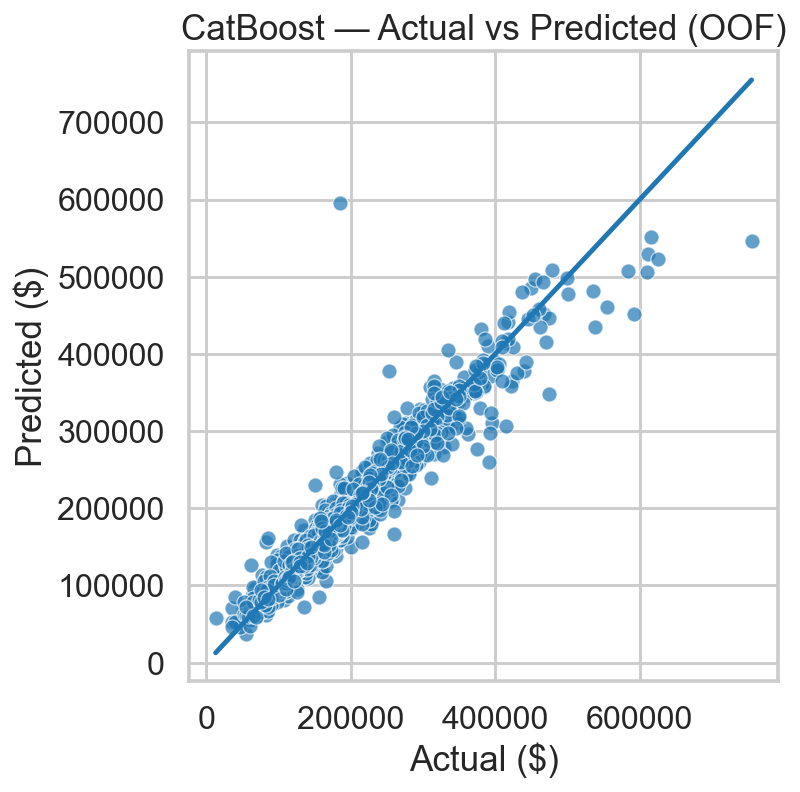

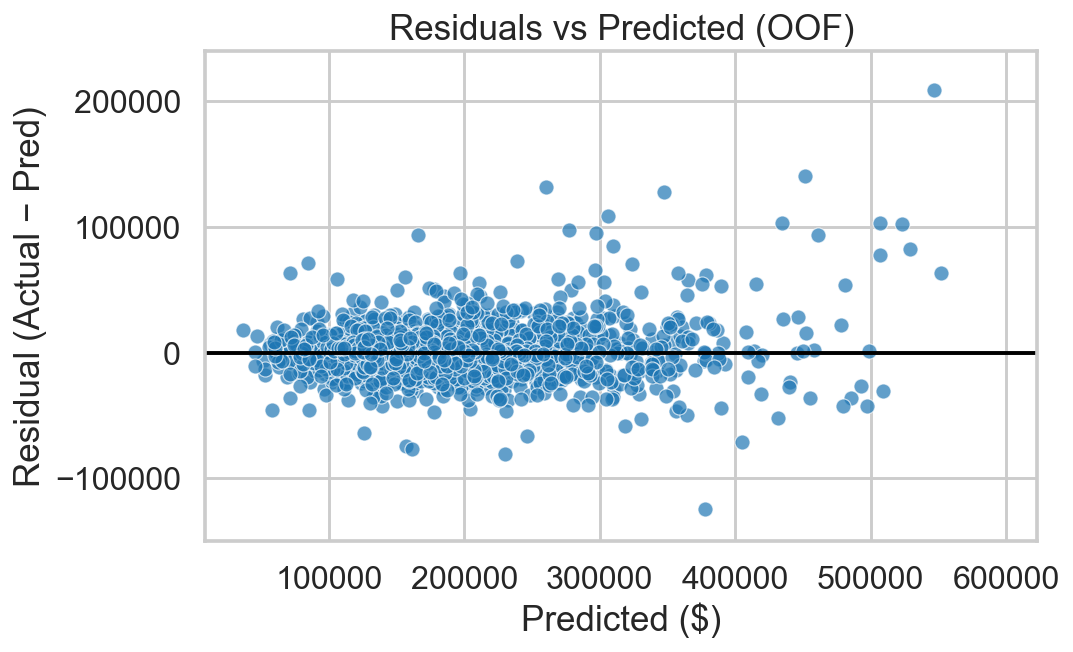

In [24]:
# OOF preds via the TTR-native helper
ttr = build_ttr_from_params(X_fe, **best_params)  # unfitted
oof_pred, fold_models, cv_stats = get_oof_predictions_ttr(ttr, X_fe, y, cv=5, random_state=42)

# Build residual tables (MAD outlier flag optional)
base_df_oof, X_oof = make_oof_tables(X_fe, y, oof_pred, row_id=Ames.index, outlier_rule="mad", k=3.5)

# Parity (OOF)
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid"); sns.set_context("talk")
plt.figure(figsize=(6,6), dpi=140)
plt.scatter(base_df_oof["y_true"], base_df_oof["oof_pred"], alpha=0.7, edgecolor="white", linewidth=0.6, s=60)
lims = [float(min(base_df_oof["y_true"].min(), base_df_oof["oof_pred"].min())),
        float(max(base_df_oof["y_true"].max(), base_df_oof["oof_pred"].max()))]
plt.plot(lims, lims, lw=2.5)
plt.title("CatBoost — Actual vs Predicted (OOF)")
plt.xlabel("Actual ($)"); plt.ylabel("Predicted ($)")
plt.tight_layout(); plt.show()

# Residuals vs predicted (OOF)
resid = base_df_oof["residual"].to_numpy()
pred  = base_df_oof["oof_pred"].to_numpy()
plt.figure(figsize=(8,5), dpi=140)
plt.scatter(pred, resid, alpha=0.7, edgecolor="white", linewidth=0.6, s=60)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted (OOF)")
plt.xlabel("Predicted ($)"); plt.ylabel("Residual (Actual − Pred)")
plt.ylim(bottom=-150000) 
plt.tight_layout(); plt.show()

In [18]:
import numpy as np, pandas as pd
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.base import clone
from catboost import Pool

def oof_shap_mean_abs(ttr_estimator, X, y, *, cv=5, random_state=42):
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    sum_abs = defaultdict(float)   # feature -> sum |SHAP| over all OOF rows
    total_rows = 0
    all_feats = set()

    for tr, va in kf.split(X):
        est = clone(ttr_estimator).fit(X.iloc[tr], y.iloc[tr])

        prep = est.regressor_.named_steps["prep"]
        cb   = est.regressor_.named_steps["reg"]

        X_va_prep = prep.transform(X.iloc[va])
        feats = prep.get_feature_names_out()
        all_feats.update(feats)

        shap_mat = cb.get_feature_importance(Pool(X_va_prep), type="ShapValues")
        vals = np.abs(shap_mat[:, :-1])        # (n_val, n_features_in_this_fold)
        fold_sum = vals.sum(axis=0)            # sum |SHAP| per feature over val rows

        # accumulate by name
        for f, s in zip(feats, fold_sum):
            sum_abs[f] += float(s)

        total_rows += len(va)

    # mean |SHAP| across ALL rows (OOF)
    data = [(f, sum_abs.get(f, 0.0) / total_rows) for f in all_feats]
    return (pd.DataFrame(data, columns=["feature", "mean_abs_shap"])
              .sort_values("mean_abs_shap", ascending=False)
              .reset_index(drop=True))

In [19]:
ttr = build_ttr_from_params(X_fe, **best_params)
oof_shap_df = oof_shap_mean_abs(ttr, X_fe, y, cv=5, random_state=42)

In [32]:
# --- Upgrades list (your list) ---
UPGRADES = [
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

In [26]:
# def select_flip_candidates(base_df_oof: pd.DataFrame, frac: float = 0.30,
#                            drop_outliers: bool = False, outlier_col: str = "is_outlier"):
#     df = base_df_oof.copy()
#     if drop_outliers and outlier_col in df.columns:
#         df = df.loc[~df[outlier_col].astype(bool)].copy()
#     k = max(1, int(len(df) * frac))
#     return df.nsmallest(k, "residual").reset_index(drop=True)  # most negative residuals

In [49]:
def select_flip_candidates(base_df_oof: pd.DataFrame, frac: float = 0.30,
                           drop_outliers: bool = False, outlier_col: str = "is_outlier"):
    df = base_df_oof.copy()
    if drop_outliers and outlier_col in df.columns:
        df = df.loc[~df[outlier_col].astype(bool)].copy()
    k = max(1, int(len(df) * frac))
    return df.nsmallest(k, "residual").reset_index(drop=True)  # most negative residuals

In [51]:
candidates = select_flip_candidates(base_df_oof, frac=0.30, drop_outliers=False)

In [52]:
import numpy as np
import pandas as pd

def _apply_delta_numeric(df, col, delta):
    df[col] = pd.to_numeric(df[col], errors="coerce") + delta
    return df

def _apply_step_ordinal(df, col, *, order, step):
    cat = pd.Categorical(df[col], categories=order, ordered=True)
    codes = cat.codes
    valid = codes >= 0
    newc  = codes.copy()
    newc[valid] = np.clip(newc[valid] + step, 0, len(order)-1)
    df[col] = pd.Categorical.from_codes(newc, categories=order, ordered=True).astype(object)
    return df

def _apply_to_best(df, col, *, order):
    top = order[-1]
    m = df[col].notna()
    df.loc[m, col] = top
    return df

In [53]:
from tqdm.auto import tqdm

def simulate_upgrades_oof_gold(
    X: pd.DataFrame,
    base_df_oof: pd.DataFrame,          # has _idx, row_id, oof_pred, residual, etc.
    candidates: pd.DataFrame,            # subset of base_df_oof
    fold_models: list,                   # from get_oof_predictions_ttr
    val_splits: list,                    # list of validation index arrays
    upgrades: list,                      # your UPGRADES list
    ordinal_map: dict,                   # ORDINAL_ORDER
    show_progress: bool = True,
    eps: float = 1e-9
):
    """
    Returns:
      summary_oof : one row per candidate with best single-upgrade (best_uplift ≥ 0)
      upgrades_long_oof : long table over (candidate × upgrade) with new_pred, uplift, uplift_pct
    """
    # Convenience lookups
    cand_idx = set(candidates["_idx"].tolist())
    oof_lookup = base_df_oof.set_index("_idx")["oof_pred"].to_dict()
    rowid_lookup = base_df_oof.set_index("_idx")["row_id"].to_dict() if "row_id" in base_df_oof.columns else {}

    long_chunks = []
    best_rows   = []

    fold_iter = range(len(fold_models))
    if show_progress:
        fold_iter = tqdm(fold_iter, desc="Gold OOF sims (folds)", unit="fold")

    for f in fold_iter:
        est = fold_models[f]         # fitted TTR for this fold
        va_idx = val_splits[f]       # absolute indices into X
        # map absolute indices to our positional _idx (we used 0..n-1)
        # if your _idx is exactly the row position, we can use it directly
        # else ensure base_df_oof['_idx'] == np.arange(len(X))
        fold_mask = np.isin(va_idx, list(cand_idx))
        if not np.any(fold_mask):
            continue

        sel_abs = va_idx[fold_mask]
        X_val = X.iloc[sel_abs].copy()
        base_pred_model = est.predict(X_val).astype(float)   # dollars from this fold model

        # For safety, we use the model's own baseline; if you want to assert closeness to oof_pred:
        # assert np.allclose(base_pred_model, base_df_oof.loc[base_df_oof["_idx"].isin(sel_abs), "oof_pred"].to_numpy(), rtol=1e-5, atol=1e-5)

        # Build all modified versions for these rows
        blocks = []
        meta   = []
        for upg in upgrades:
            ftr = upg["feature"]
            if ftr not in X_val.columns:
                continue
            Xm = X_val.copy()
            if "delta" in upg:
                Xm = _apply_delta_numeric(Xm, ftr, upg["delta"])
            elif "step" in upg:
                order = ordinal_map.get(ftr)
                if not order: 
                    continue
                Xm = _apply_step_ordinal(Xm, ftr, order=order, step=upg["step"])
            elif upg.get("to") == "best":
                order = ordinal_map.get(ftr)
                if not order: 
                    continue
                Xm = _apply_to_best(Xm, ftr, order=order)
            else:
                continue
            blocks.append(Xm)
            meta.append((upg["upgrade"], ftr))

        if not blocks:
            # No valid upgrades for this fold’s candidates — all zero uplift
            for _i, abs_i in enumerate(sel_abs):
                idx = int(abs_i)
                rid = rowid_lookup.get(idx, np.nan)
                bp  = float(base_pred_model[_i])
                best_rows.append({
                    "_idx": idx, "row_id": rid, "best_upgrade": None, "best_feature": None,
                    "best_new_pred": bp, "best_uplift": 0.0, "best_uplift_pct": 0.0
                })
            continue

        bigX = pd.concat(blocks, axis=0, ignore_index=True)
        new_pred_all = est.predict(bigX).astype(float)

        # repeat keys to align
        rep = len(blocks)
        rep_idx   = np.tile(sel_abs, rep)
        rep_rowid = np.tile([rowid_lookup.get(int(i), np.nan) for i in sel_abs], rep)
        rep_base  = np.tile(base_pred_model, rep)

        up_long = pd.DataFrame({
            "_idx":    rep_idx.astype(int),
            "row_id":  rep_rowid,
            "upgrade": np.concatenate([[m[0]]*len(sel_abs) for m in meta]),
            "feature": np.concatenate([[m[1]]*len(sel_abs) for m in meta]),
            "new_pred": new_pred_all,
            "base_pred_model": rep_base,
        })
        up_long["uplift"]     = up_long["new_pred"] - up_long["base_pred_model"]
        up_long["uplift_pct"] = up_long["uplift"] / np.maximum(up_long["base_pred_model"], eps)
        long_chunks.append(up_long)

        # best single upgrade per row (allow no-upgrade)
        best_this_fold = (
            up_long.sort_values(["_idx","uplift"], ascending=[True, False])
                   .groupby("_idx", as_index=False).first()
        )
        # add do-nothing clamp
        neg_mask = best_this_fold["uplift"] <= 0
        # baseline per row from this fold model
        base_map = {int(i): float(p) for i, p in zip(sel_abs, base_pred_model)}
        best_this_fold["best_new_pred"] = best_this_fold.apply(
            lambda r: base_map[int(r["_idx"])] if r["uplift"] <= 0 else r["new_pred"], axis=1
        )
        best_this_fold["best_uplift"]     = best_this_fold.apply(lambda r: max(0.0, float(r["uplift"])), axis=1)
        best_this_fold["best_uplift_pct"] = best_this_fold["best_uplift"] / best_this_fold["_idx"].map(base_map)  # temp; fix below with eps

        # finalize rows
        for _, r in best_this_fold.iterrows():
            idx = int(r["_idx"]); rid = rowid_lookup.get(idx, np.nan)
            bp  = base_map[idx]
            bu  = float(max(0.0, r["uplift"]))
            bnp = float(r["best_new_pred"])
            bup = bu / max(bp, eps)
            upg = None if bu == 0.0 else str(r["upgrade"])
            ftr = None if bu == 0.0 else str(r["feature"])
            best_rows.append({
                "_idx": idx, "row_id": rid, "best_upgrade": upg, "best_feature": ftr,
                "best_new_pred": bnp, "best_uplift": bu, "best_uplift_pct": bup
            })

    upgrades_long_oof = (pd.concat(long_chunks, ignore_index=True) if long_chunks
                         else pd.DataFrame(columns=["_idx","row_id","upgrade","feature","new_pred",
                                                    "base_pred_model","uplift","uplift_pct"]))
    summary_oof = pd.DataFrame(best_rows).sort_values(["best_uplift","_idx"], ascending=[False, True]).reset_index(drop=True)

    # Add OOF context columns (y_true, oof_pred, residual, etc.)
    keep_cols = ["_idx","row_id","y_true","oof_pred","residual","abs_resid","is_outlier"]
    keep_cols = [c for c in keep_cols if c in base_df_oof.columns]
    summary_oof = summary_oof.merge(base_df_oof[keep_cols], on=["_idx","row_id"], how="left")
    # Friendly order
    front = ["_idx","row_id","y_true","oof_pred","residual","best_upgrade","best_feature",
             "best_new_pred","best_uplift","best_uplift_pct"]
    front = [c for c in front if c in summary_oof.columns]
    summary_oof = summary_oof.loc[:, front + [c for c in summary_oof.columns if c not in front]]

    return summary_oof, upgrades_long_oof

In [54]:
# A) Build the UNFITTED TTR with your tuned params
ttr_unfitted = build_ttr_from_params(X_fe, **best_params)

# B) Get OOF preds (and folds) once
oof_pred, fold_models, cv_stats, val_splits = get_oof_predictions_ttr(
    ttr_unfitted, X_fe, y, cv=5, random_state=42, show_progress=True
)

# C) Build the authoritative OOF table (from earlier)
base_df_oof, X_oof = make_oof_tables(
    X_fe, y, oof_pred, row_id=Ames.index, outlier_rule="mad", k=3.5
)

# D) Choose flip candidates (bottom 30% residual)
candidates = select_flip_candidates(base_df_oof, frac=0.30, drop_outliers=False)

# E) Gold-standard, per-fold upgrade sims (progress shown)
summary_oof, upgrades_long_oof = simulate_upgrades_oof_gold(
    X=X_fe,
    base_df_oof=base_df_oof,
    candidates=candidates,
    fold_models=fold_models,
    val_splits=val_splits,
    upgrades=UPGRADES,
    ordinal_map=ORDINAL_ORDER,
    show_progress=True
)

print("Summary shape:", summary_oof.shape)
print("Upgrades long shape:", upgrades_long_oof.shape)
print(summary_oof.head(10))

5-fold OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

Gold OOF sims (folds):   0%|          | 0/5 [00:00<?, ?fold/s]

Summary shape: (774, 12)
Upgrades long shape: (9288, 8)
   _idx  row_id  y_true       oof_pred       residual  \
0   942     943  386250  419016.718932  -32766.718932   
1   529     530  277500  297127.200406  -19627.200406   
2  1735     736  180000  246366.281730  -66366.281730   
3   962     963  412500  439835.153461  -27335.153461   
4   290     291  479069  509179.577614  -30110.577614   
5  1317     318  410000  416997.623285   -6997.623285   
6   309     310  184750  595098.441868 -410348.441868   
7    63      64  390000  409728.493672  -19728.493672   
8   781     782  334000  405327.955456  -71327.955456   
9   289     290  167000  192120.064681  -25120.064681   

               best_upgrade best_feature  best_new_pred   best_uplift  \
0           TotalBaths +1.0   TotalBaths  446221.044392  27204.325460   
1  KitchenQual → best (max)  KitchenQual  319001.108174  21873.907768   
2  KitchenQual → best (max)  KitchenQual  265699.395779  19333.114049   
3    ExterQual → best (m

In [60]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# --- tiny mutators reused below ---
def _apply_delta_numeric(df, col, delta):
    df[col] = pd.to_numeric(df[col], errors="coerce") + delta
    return df

def _apply_step_ordinal(df, col, *, order, step):
    cat = pd.Categorical(df[col], categories=order, ordered=True)
    codes = cat.codes; valid = codes >= 0
    newc = codes.copy(); newc[valid] = np.clip(newc[valid] + step, 0, len(order)-1)
    df[col] = pd.Categorical.from_codes(newc, categories=order, ordered=True).astype(object)
    return df

def _apply_to_best(df, col, *, order):
    top = order[-1]
    m = df[col].notna()
    df.loc[m, col] = top
    return df

# --- per-row greedy planner with a single (fold) model ---
def _greedy_stack_row(
    est, X_row: pd.DataFrame, *, upgrades: list, ordinal_map: dict,
    group_map: dict[str, str] | None = None, max_steps: int = 6, eps: float = 1e-9
) -> tuple[pd.DataFrame, float]:
    """
    est        : fitted TTR for THIS fold
    X_row      : DataFrame shape (1, n_features)
    upgrades   : list of dicts like your UPGRADES
    ordinal_map: ORDINAL_ORDER
    group_map  : feature -> group string (enforces 'one-per-group' total)
    Returns:
      plan_df      : rows per chosen step with uplift & cumulative uplift
      final_pred   : final predicted price after applied steps
    """
    group_map = group_map or {}
    used_groups: set[str] = set()
    plan = []

    curr_pred = float(est.predict(X_row)[0])
    X_curr = X_row.copy()

    for step_idx in range(1, max_steps + 1):
        cands = []
        for upg in upgrades:
            f = upg["feature"]
            if f not in X_curr.columns:
                continue
            g = group_map.get(f)
            if g and g in used_groups:
                continue

            Xm = X_curr.copy()
            if "delta" in upg:
                Xm = _apply_delta_numeric(Xm, f, upg["delta"])
            elif "step" in upg:
                order = ordinal_map.get(f)
                if not order: 
                    continue
                Xm = _apply_step_ordinal(Xm, f, order=order, step=upg["step"])
            elif upg.get("to") == "best":
                order = ordinal_map.get(f)
                if not order: 
                    continue
                Xm = _apply_to_best(Xm, f, order=order)
            else:
                continue

            pred_new = float(est.predict(Xm)[0])
            uplift = pred_new - curr_pred
            cands.append((uplift, upg, pred_new, Xm, g))

        if not cands:
            break

        # pick best marginal uplift
        uplift, upg, pred_new, Xm, g = max(cands, key=lambda x: x[0])

        # stop if no positive uplift (do-nothing wins)
        if uplift <= 0:
            break

        plan.append({
            "step": step_idx,
            "upgrade": upg["upgrade"],
            "feature": upg["feature"],
            "new_pred": pred_new,
            "uplift": uplift,
            "uplift_pct": uplift / max(curr_pred, eps),
        })
        curr_pred = pred_new
        X_curr = Xm
        if g: 
            used_groups.add(g)

    plan_df = pd.DataFrame(plan)
    return plan_df, curr_pred

# --- gold-standard stacking over folds ---
def simulate_stacking_oof_gold(
    X: pd.DataFrame,
    base_df_oof: pd.DataFrame,      # has _idx, row_id, oof_pred, residual
    candidates: pd.DataFrame,        # subset of base_df_oof (bottom-30% residuals)
    fold_models: list,               # fitted TTR per fold (from get_oof_predictions_ttr)
    val_splits: list,                # validation index arrays per fold
    upgrades: list,                  # your UPGRADES
    ordinal_map: dict,               # ORDINAL_ORDER
    group_map: dict[str,str] | None = None,  # mutual-exclusion groups
    max_steps: int = 6,
    show_progress: bool = True,
    eps: float = 1e-9,
):
    cand_set = set(candidates["_idx"].tolist())
    rowid_lookup = base_df_oof.set_index("_idx")["row_id"].to_dict() if "row_id" in base_df_oof.columns else {}
    # optional: for context in final summary
    ctx_cols = ["_idx","row_id","y_true","oof_pred","residual","abs_resid","is_outlier"]
    ctx_cols = [c for c in ctx_cols if c in base_df_oof.columns]
    oof_ctx = base_df_oof[ctx_cols].copy()

    plans_all = []
    summary_rows = []

    fold_iter = range(len(fold_models))
    if show_progress:
        fold_iter = tqdm(fold_iter, desc="Gold OOF greedy stacking (folds)", unit="fold")

    for f in fold_iter:
        est = fold_models[f]
        va_idx = val_splits[f]

        # restrict to candidate rows in this fold's validation slice
        sel_mask = np.isin(va_idx, list(cand_set))
        if not np.any(sel_mask):
            continue

        sel_abs = va_idx[sel_mask]
        # progress inner loop
        row_iter = sel_abs
        if show_progress:
            row_iter = tqdm(sel_abs, desc=f"fold {f+1}: rows", leave=False)

        for abs_i in row_iter:
            idx = int(abs_i)
            rid = rowid_lookup.get(idx, np.nan)
            X_row = X.iloc[[idx]].copy()

            # baseline from this fold model
            base_pred_model = float(est.predict(X_row)[0])

            # greedy plan
            plan_df, final_pred = _greedy_stack_row(
                est, X_row, upgrades=upgrades, ordinal_map=ordinal_map,
                group_map=group_map, max_steps=max_steps, eps=eps
            )

            # record per-step plan
            if not plan_df.empty:
                plan_df = plan_df.copy()
                plan_df.insert(0, "_idx", idx)
                plan_df.insert(1, "row_id", rid)
                # add cumulative uplift columns
                plan_df["cum_new_pred"] = plan_df["new_pred"].cummax()
                plan_df["cum_uplift"]   = plan_df["cum_new_pred"] - base_pred_model
                plan_df["cum_uplift_pct"] = plan_df["cum_uplift"] / max(base_pred_model, eps)
                plans_all.append(plan_df)

            # summarize final stacked outcome (allow zero steps)
            total_uplift = (plan_df["cum_uplift"].iloc[-1] if not plan_df.empty else 0.0)
            total_uplift_pct = total_uplift / max(base_pred_model, eps)
            summary_rows.append({
                "_idx": idx,
                "row_id": rid,
                "steps": int(plan_df["step"].max()) if not plan_df.empty else 0,
                "final_pred_model": float(final_pred if not plan_df.empty else base_pred_model),
                "total_uplift": float(total_uplift),
                "total_uplift_pct": float(total_uplift_pct),
                "baseline_pred_model": float(base_pred_model),
            })

    stacked_plans = pd.concat(plans_all, ignore_index=True) if plans_all else pd.DataFrame(
        columns=["_idx","row_id","step","upgrade","feature","new_pred","uplift","uplift_pct","cum_new_pred","cum_uplift","cum_uplift_pct"]
    )
    stacked_summary = pd.DataFrame(summary_rows).sort_values(
        ["total_uplift","steps","_idx"], ascending=[False, False, True]
    ).reset_index(drop=True)

    # add OOF context for convenience
    stacked_summary = stacked_summary.merge(oof_ctx, on=["_idx","row_id"], how="left")

    # friendly column order
    front = ["_idx","row_id","y_true","oof_pred","residual","baseline_pred_model",
             "steps","final_pred_model","total_uplift","total_uplift_pct"]
    front = [c for c in front if c in stacked_summary.columns]
    stacked_summary = stacked_summary.loc[:, front + [c for c in stacked_summary.columns if c not in front]]

    return stacked_summary, stacked_plans

In [61]:
# Any change to ExterQual competes with other ExterQual changes, etc.
GROUP_MAP = {
    "ExterQual": "ExterQual",
    "KitchenQual": "KitchenQual",
    # add more families if you introduce stepwise + best variants for others
}

In [62]:
stacked_summary, stacked_plans = simulate_stacking_oof_gold(
    X=X_fe,
    base_df_oof=base_df_oof,
    candidates=candidates,
    fold_models=fold_models,
    val_splits=val_splits,
    upgrades=UPGRADES,
    ordinal_map=ORDINAL_ORDER,
    group_map=GROUP_MAP,     # or None if you want to allow multiple per family
    max_steps=6,
    show_progress=True
)

print("Stacked summary:", stacked_summary.shape)
print("Stacked plans:", stacked_plans.shape)
print(stacked_summary.head(10))
print(stacked_plans.head(10))

Gold OOF greedy stacking (folds):   0%|          | 0/5 [00:00<?, ?fold/s]

fold 1: rows:   0%|          | 0/157 [00:00<?, ?it/s]

fold 2: rows:   0%|          | 0/156 [00:00<?, ?it/s]

fold 3: rows:   0%|          | 0/159 [00:00<?, ?it/s]

fold 4: rows:   0%|          | 0/157 [00:00<?, ?it/s]

fold 5: rows:   0%|          | 0/145 [00:00<?, ?it/s]

Stacked summary: (774, 12)
Stacked plans: (4642, 11)
   _idx  row_id  y_true       oof_pred      residual  baseline_pred_model  \
0  1918     102  325000  339157.200431 -14157.200431        339157.200431   
1   942     943  386250  419016.718932 -32766.718932        419016.718932   
2   626     627  246500  264878.670803 -18378.670803        264878.670803   
3   614     615  257000  264733.091810  -7733.091810        264733.091810   
4   290     291  479069  509179.577614 -30110.577614        509179.577614   
5   217     218  345474  389754.810789 -44280.810789        389754.810789   
6  1437     438  372500  378540.496912  -6040.496912        378540.496912   
7   529     530  277500  297127.200406 -19627.200406        297127.200406   
8  1826      10  239000  280367.275298 -41367.275298        280367.275298   
9  1521     522  227000  253977.856506 -26977.856506        253977.856506   

   steps  final_pred_model  total_uplift  total_uplift_pct     abs_resid  \
0      6     394278.627

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_selection_rate(base_df_oof, candidates, bins=10):
    """
    Plot % of homes selected as candidates within each price decile.
    """
    # Assign deciles to the full dataset
    deciles = pd.qcut(base_df_oof["y_true"], q=bins, labels=False, duplicates="drop")
    base_df_oof = base_df_oof.assign(decile=deciles)

    # Mark which homes were selected
    sel_flag = pd.Series(False, index=base_df_oof.index)
    sel_flag.loc[candidates["_idx"]] = True
    base_df_oof = base_df_oof.assign(selected=sel_flag.values)

    # Compute selection rate per decile
    rate = (base_df_oof.groupby("decile")["selected"]
                       .mean()
                       .reset_index(name="selection_rate"))
    rate["decile_label"] = "D" + (rate["decile"] + 1).astype(str)

    # Plot
    plt.figure(figsize=(9,6), dpi=140)
    sns.barplot(data=rate, x="decile_label", y="selection_rate", color="#0B6B6E")
    plt.axhline(0.30, color="red", linestyle="--", lw=2)  # target selection rate
    plt.ylabel("Share Selected (%)")
    plt.xlabel("Sale Price Decile")
    plt.title("Candidate Selection Rate by Price Decile", fontsize=14, weight="bold")
    plt.gca().yaxis.set_major_formatter(lambda y, _: f"{y*100:.0f}")
    plt.tight_layout()
    plt.show()

    return rate

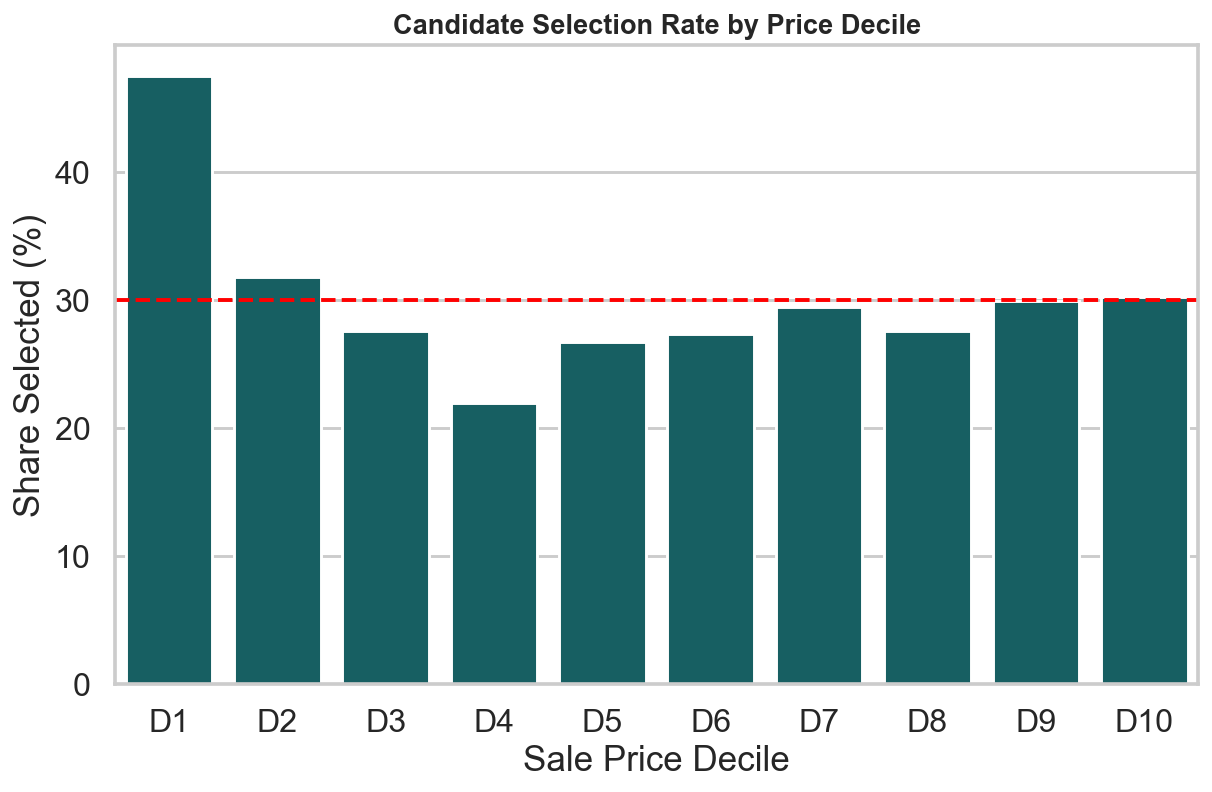

   decile  selection_rate decile_label
0       0        0.474903           D1
1       1        0.317829           D2
2       2        0.275472           D3
3       3        0.219608           D4
4       4        0.266667           D5
5       5        0.273438           D6
6       6        0.294574           D7
7       7        0.275472           D8
8       8        0.298805           D9
9       9        0.302326          D10


In [102]:
rate = plot_selection_rate(base_df_oof, candidates, bins=10)
print(rate)

In [105]:
stacked_summary

,_idx,row_id,y_true,oof_pred,residual,baseline_pred_model,steps,final_pred_model,total_uplift,total_uplift_pct,abs_resid,is_outlier
0,1918,102,325000,339157.200431,-14157.200431,339157.200431,6,394278.627117,55121.426686,0.162525,14157.200431,False
1,942,943,386250,419016.718932,-32766.718932,419016.718932,6,472501.767265,53485.048333,0.127644,32766.718932,False
2,626,627,246500,264878.670803,-18378.670803,264878.670803,6,318313.093485,53434.422682,0.201732,18378.670803,False
3,614,615,257000,264733.091810,-7733.091810,264733.091810,6,316796.013894,52062.922085,0.196662,7733.091810,False
4,290,291,479069,509179.577614,-30110.577614,509179.577614,6,560997.162864,51817.585250,0.101767,30110.577614,False
...,...,...,...,...,...,...,...,...,...,...,...,...
769,512,513,253293,377913.361461,-124620.361461,377913.361461,6,390403.754723,12490.393262,0.033051,124620.361461,True
770,1715,716,135000,145619.350779,-10619.350779,145619.350779,6,157795.635180,12176.284401,0.083617,10619.350779,False
771,770,771,95000,101499.552228,-6499.552228,101499.552228,6,113069.331920,11569.779692,0.113988,6499.552228,False
772,644,645,35311,52736.793444,-17425.793444,52736.793444,6,64299.848041,11563.054597,0.219260,17425.793444,False


In [106]:
def select_dual_filter(candidates_stacked: pd.DataFrame,
                       min_uplift_dollars: float = 20000,
                       top_frac: float = 0.20,
                       dollar_col: str = "total_uplift",
                       pct_col: str = "total_uplift_pct"):
    """
    Dual filter:
      1. Keep candidates with at least `min_uplift_dollars`.
      2. Among those, select top_frac (e.g., 0.20) by percent uplift.
    """
    # Step 1: filter by dollar uplift
    filt = candidates_stacked[candidates_stacked[dollar_col] >= min_uplift_dollars]

    # Step 2: select top fraction by percent uplift
    k = max(1, int(len(filt) * top_frac))
    top = filt.nlargest(k, pct_col).copy()

    return top, filt


# Example usage
top20pct, filtered = select_dual_filter(
    stacked_summary,
    min_uplift_dollars=20000,
    top_frac=0.20
)

print(f"After $ filter: {filtered.shape[0]} candidates remain")
print(f"Selected top 20% by % uplift: {top20pct.shape[0]} candidates")
print(top20pct.head())

After $ filter: 541 candidates remain
Selected top 20% by % uplift: 108 candidates
     _idx  row_id  y_true      oof_pred      residual  baseline_pred_model  \
446  1978     162   58500  65228.476228  -6728.476228         65228.476228   
399    37      38   61500  70045.821993  -8545.821993         70045.821993   
402  1611     612   64000  71235.199920  -7235.199920         71235.199920   
250  2221     405   81400  89406.691323  -8006.691323         89406.691323   
461  2181     365   64000  78918.956143 -14918.956143         78918.956143   

     steps  final_pred_model  total_uplift  total_uplift_pct     abs_resid  \
446      6      86769.769206  21541.292979          0.330244   6728.476228   
399      6      92463.050008  22417.228016          0.320037   8545.821993   
402      6      93605.621183  22370.421263          0.314036   7235.199920   
250      6     115500.545970  26093.854647          0.291856   8006.691323   
461      6     100220.339861  21301.383717          0.2699

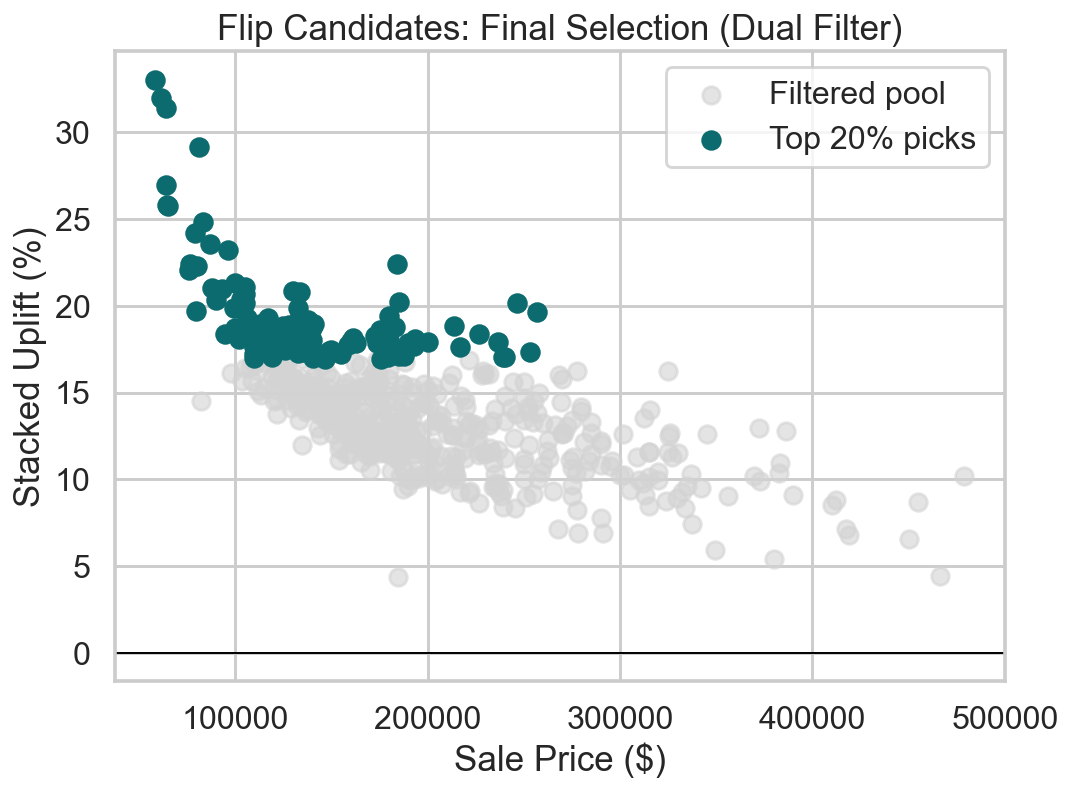

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6), dpi=140)
plt.scatter(filtered["y_true"], filtered["total_uplift_pct"]*100,
            c="lightgray", alpha=0.6, label="Filtered pool")
plt.scatter(top20pct["y_true"], top20pct["total_uplift_pct"]*100,
            c="#0B6B6E", label="Top 20% picks")
plt.axhline(0, color="black", lw=1)
plt.xlabel("Sale Price ($)")
plt.ylabel("Stacked Uplift (%)")
plt.title("Flip Candidates: Final Selection (Dual Filter)")
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
import numpy as np
import pandas as pd

def build_stack_sequences(stacked_plans: pd.DataFrame) -> pd.DataFrame:
    if stacked_plans is None or stacked_plans.empty:
        return pd.DataFrame(columns=["_idx","stack_sequence","final_pred_model","stacked_uplift","stacked_uplift_pct"])
    sp = stacked_plans.copy().sort_values(["_idx","step"])
    sp["step_label"] = sp.apply(
        lambda r: f"{int(r['step'])}) {r['upgrade']} (+${r['uplift']:,.0f}, {r['uplift_pct']*100:.1f}%)", axis=1
    )
    seq = sp.groupby("_idx")["step_label"].apply("  |  ".join)
    out = pd.DataFrame({
        "_idx": seq.index,
        "stack_sequence": seq.values,
        "final_pred_model": sp.groupby("_idx")["cum_new_pred"].max().values,
        "stacked_uplift": sp.groupby("_idx")["cum_uplift"].max().values,
        "stacked_uplift_pct": sp.groupby("_idx")["cum_uplift_pct"].max().values,
    })
    return out

def attach_sequences(stacked_summary: pd.DataFrame, stacked_plans: pd.DataFrame) -> pd.DataFrame:
    seq_df = build_stack_sequences(stacked_plans)

    df = stacked_summary.copy()

    # 1) ensure cols exist even before merge
    if "final_pred_model" not in df.columns:
        df["final_pred_model"] = df.get("baseline_pred_model", np.nan)
    if "stacked_uplift" not in df.columns:
        df["stacked_uplift"] = 0.0
    if "stacked_uplift_pct" not in df.columns:
        df["stacked_uplift_pct"] = 0.0
    if "stack_sequence" not in df.columns:
        df["stack_sequence"] = "(no upgrades)"

    # 2) merge sequence info
    df = df.merge(
        seq_df[["_idx","stack_sequence","final_pred_model","stacked_uplift","stacked_uplift_pct"]],
        on="_idx", how="left", suffixes=("", "_seq")
    )

    # 3) coalesce (prefer sequence-derived columns when present)
    for col in ["final_pred_model","stacked_uplift","stacked_uplift_pct","stack_sequence"]:
        seq_col = f"{col}_seq"
        if seq_col in df.columns:
            df[col] = df[seq_col].where(df[seq_col].notna(), df[col])
            df.drop(columns=[seq_col], inplace=True)

    # fill any remaining gaps
    df["stack_sequence"] = df["stack_sequence"].fillna("(no upgrades)")
    df["stacked_uplift"] = df["stacked_uplift"].fillna(0.0)
    df["stacked_uplift_pct"] = df["stacked_uplift_pct"].fillna(0.0)
    df["final_pred_model"] = df["final_pred_model"].fillna(df.get("baseline_pred_model", np.nan))
    return df

# --- use it ---
candidates_stacked = attach_sequences(stacked_summary, stacked_plans)

# Dual-filter (≥ $20k, then top 20% by % uplift)
def select_dual_filter(candidates_stacked: pd.DataFrame,
                       min_uplift_dollars: float = 20000,
                       top_frac: float = 0.20,
                       dollar_col: str = "stacked_uplift",
                       pct_col: str = "stacked_uplift_pct"):
    filt = candidates_stacked[candidates_stacked[dollar_col] >= min_uplift_dollars].copy()
    k = max(1, int(len(filt) * top_frac))
    top = filt.nlargest(k, pct_col).copy()
    return top, filt

top20pct, filtered = select_dual_filter(candidates_stacked, min_uplift_dollars=20000, top_frac=0.20)

In [145]:
# import pandas as pd
# import numpy as np

# CATEGORICAL_EXPLICIT = {"Neighborhood","MSZoning","KitchenQual","ExterQual"}
# YEAR_LIKE = {"YearBuilt","YearRemodAdd"}

# def compare_feature_groups(X: pd.DataFrame,
#                            top20pct: pd.DataFrame,
#                            candidates: pd.DataFrame,
#                            feat_cols: list[str]) -> dict[str, pd.DataFrame]:
#     """
#     Compare top20pct vs candidates vs all_data on the given features.

#     - Uses .iloc with `_idx` (position-based) to slice X safely.
#     - Categorical: returns a table of % shares (rows = categories; cols = groups).
#     - Year-like: returns mean/median only (no % diff).
#     - Other numeric: returns mean and % diff vs all_data.

#     Returns: dict[feature] -> DataFrame
#     """
#     # --- build group frames (position-based indexing) ---
#     groups = {
#         "all_data": X,
#         "candidates": X.iloc[candidates["_idx"]],
#         "top20pct": X.iloc[top20pct["_idx"]],
#     }

#     out: dict[str, pd.DataFrame] = {}

#     for feat in feat_cols:
#         is_cat = (feat in CATEGORICAL_EXPLICIT) or (X[feat].dtype == "object")
#         is_year = feat in YEAR_LIKE

#         if is_cat:
#             # categorical: normalized value counts (%)
#             # union of categories across groups for stable row index
#             cats = pd.Index([])
#             tmp = {}
#             for gname, gdf in groups.items():
#                 vc = gdf[feat].astype("object").value_counts(dropna=False, normalize=True)
#                 tmp[gname] = vc
#                 cats = cats.union(vc.index.astype("object"))
#             comp = pd.DataFrame({g: tmp.get(g, pd.Series(dtype=float)) for g in groups}).reindex(cats).fillna(0.0)
#             comp.index.name = feat
#             out[feat] = comp.sort_index()

#         elif is_year:
#             # year-like numeric: mean / median only
#             comp = {
#                 gname: {
#                     "mean": float(gdf[feat].mean()),
#                     "median": float(gdf[feat].median())
#                 }
#                 for gname, gdf in groups.items()
#             }
#             out[feat] = pd.DataFrame(comp)

#         else:
#             # numeric continuous: mean and % diff vs all_data
#             base_mean = float(groups["all_data"][feat].mean())
#             comp = {}
#             for gname, gdf in groups.items():
#                 m = float(gdf[feat].mean())
#                 pct = (m - base_mean) / base_mean * 100.0 if base_mean != 0 else np.nan
#                 comp[gname] = {"mean": m, "pct_diff_vs_all": pct}
#             out[feat] = pd.DataFrame(comp)

#     return out

In [146]:
# FEAT_COLS = [
#     "Neighborhood","MSZoning","KitchenQual","ExterQual",
#     "OverallQual","GrLivArea","TotalBaths","GarageArea",
#     "TotalSF","YearBuilt","YearRemodAdd","LotArea"
# ]

# results = compare_feature_groups(X_fe, top20pct, candidates, FEAT_COLS)

# # Example: view categorical % table
# results["KitchenQual"].head()

# # Example: view numeric summary
# results["GrLivArea"]

# # Example: year-like summary
# results["YearBuilt"]

,all_data,candidates,top20pct
mean,1970.313953,1971.351421,1955.296296
median,1972.000000,1976.000000,1959.500000


In [158]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

YEAR_LIKE = {"YearBuilt", "YearRemodAdd"}

def _safe_float_series(x: pd.Series) -> pd.Series:
    return pd.to_numeric(x, errors="coerce")

def _smd(top: np.ndarray, rest: np.ndarray) -> float:
    # Standardized mean difference with simple pooled SD
    top = top[~np.isnan(top)]
    rest = rest[~np.isnan(rest)]
    if len(top) < 2 or len(rest) < 2:
        return np.nan
    s_top = np.std(top, ddof=1)
    s_rest = np.std(rest, ddof=1)
    denom = np.sqrt((s_top**2 + s_rest**2) / 2.0)
    if denom == 0:
        return 0.0
    return (np.mean(top) - np.mean(rest)) / denom

def numeric_compare_table(
    X: pd.DataFrame,
    top_idx: pd.Index | np.ndarray,      # positional row indices (use ._idx + iloc)
    rest_idx: pd.Index | np.ndarray,     # positional row indices
    features: list[str],
    year_like: set[str] = YEAR_LIKE
) -> pd.DataFrame:
    """
    Build numeric comparison table:
      Top_mean, Rest_mean, Diff_vs_rest (abs for years, relative for others),
      SMD_vs_rest, pval_vs_rest (Welch).
    """
    X_top  = X.iloc[top_idx]
    X_rest = X.iloc[rest_idx]

    rows = []
    for feat in features:
        # skip non-numeric columns safely
        if not np.issubdtype(X[feat].dropna().infer_objects().dtype, np.number):
            continue

        a = _safe_float_series(X_top[feat]).to_numpy()
        b = _safe_float_series(X_rest[feat]).to_numpy()

        top_mean  = float(np.nanmean(a)) if a.size else np.nan
        rest_mean = float(np.nanmean(b)) if b.size else np.nan

        if feat in year_like:
            diff_vs_rest = top_mean - rest_mean
        else:
            diff_vs_rest = (top_mean - rest_mean) / rest_mean if rest_mean not in (0.0, np.nan) else np.nan

        # Welch's t-test (equal_var=False). guard for all-nan
        if np.all(np.isnan(a)) or np.all(np.isnan(b)):
            pval = np.nan
        else:
            _, pval = ttest_ind(a, b, equal_var=False, nan_policy="omit")

        rows.append({
            "feature": feat,
            "Top_mean": top_mean,
            "Rest_mean": rest_mean,
            "Diff_vs_rest": diff_vs_rest,
            "SMD_vs_rest": _smd(a, b),
            "pval_vs_rest": pval,
        })

    df = pd.DataFrame(rows)
    # nice ordering: put years first, then others by |SMD|
    df_years = df[df["feature"].isin(year_like)]
    df_other = df[~df["feature"].isin(year_like)].sort_values("SMD_vs_rest", ascending=False)
    out = pd.concat([df_years, df_other], ignore_index=True)

    # optional rounding for display
    disp = out.copy()
    disp["Top_mean"] = disp["Top_mean"].round(4)
    disp["Rest_mean"] = disp["Rest_mean"].round(4)
    # for non-year numerics, Diff_vs_rest is relative; keep as proportion (like your example)
    disp["Diff_vs_rest"] = disp.apply(
        lambda r: r["Diff_vs_rest"] if r["feature"] in year_like else round(r["Diff_vs_rest"], 6), axis=1
    )
    disp["SMD_vs_rest"] = disp["SMD_vs_rest"].round(6)
    # p-values in scientific notation
    disp["pval_vs_rest"] = disp["pval_vs_rest"].astype(float)

    return disp.reset_index(drop=True)

In [159]:
# positional indices for each group
top_idx = top20pct["_idx"].to_numpy()
cand_idx = candidates["_idx"].to_numpy()
rest_cand_idx = np.setdiff1d(cand_idx, top_idx, assume_unique=False)

NUMERIC_FEATS = [
    "OverallQual","GrLivArea","TotalBaths","GarageArea",
    "TotalSF","YearBuilt","YearRemodAdd","LotArea"
]

tbl_top_vs_candidates = numeric_compare_table(
    X_fe, top_idx, rest_cand_idx, NUMERIC_FEATS, year_like=YEAR_LIKE
)
print(tbl_top_vs_candidates)

        feature   Top_mean   Rest_mean  Diff_vs_rest  SMD_vs_rest  \
0     YearBuilt  1955.2963   1973.9550    -18.658659    -0.585318   
1  YearRemodAdd  1976.6667   1986.1336     -9.466967    -0.462967   
2       LotArea  9374.4167  10433.7132     -0.101526    -0.166354   
3    GarageArea   431.3611    498.4264     -0.134554    -0.332512   
4       TotalSF  2386.3241   2663.2673     -0.103986    -0.368439   
5     GrLivArea  1372.4722   1573.2417     -0.127615    -0.434021   
6    TotalBaths     1.9707      2.4045     -0.180407    -0.543522   
7   OverallQual     5.5278      6.3378     -0.127813    -0.595462   

   pval_vs_rest  
0  2.019549e-07  
1  2.448804e-05  
2  4.294341e-02  
3  9.920296e-04  
4  2.276840e-04  
5  9.049395e-06  
6  4.702719e-08  
7  1.998907e-08  


In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_diffs(tbl, year_like={"YearBuilt","YearRemodAdd"}):
    """
    tbl: output from numeric_compare_table (Top vs Candidates).
    year_like: features to plot separately as absolute year differences.
    """
    df = tbl.copy()
    df = df.set_index("feature")

    # split
    df_year = df.loc[df.index.intersection(year_like)]
    df_num  = df.loc[~df.index.isin(year_like)]

    # --- numeric (relative %) ---
    plt.figure(figsize=(7,4), dpi=140)
    df_num["Diff_vs_rest"].mul(100).sort_values().plot.barh(
        color=["#F4A44B" if v<0 else "#0B6B6E" for v in df_num["Diff_vs_rest"]]
    )
    plt.xlabel("%")
    plt.title("Top vs Candidates (relative mean difference)")
    plt.tight_layout()
    plt.show()

    # --- years (absolute difference) ---
    plt.figure(figsize=(7,2.5), dpi=140)
    df_year["Diff_vs_rest"].sort_values().plot.barh(
        color="#F4A44B"
    )
    plt.xlabel("years")
    plt.title("Top vs Candidates (mean difference in years)")
    plt.tight_layout()
    plt.show()

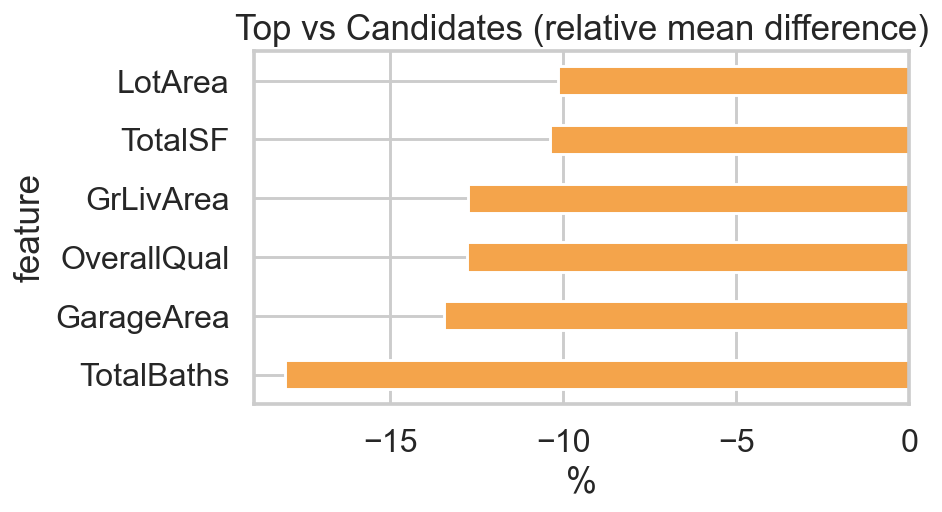

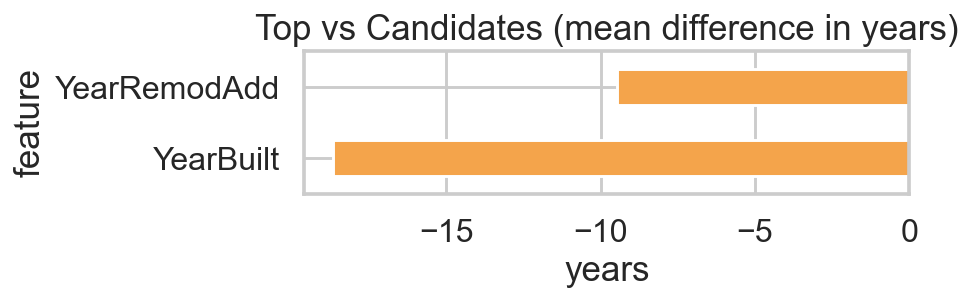

In [165]:
tbl_top_vs_candidates = numeric_compare_table(
    X_fe, top20pct["_idx"].to_numpy(),
    np.setdiff1d(candidates["_idx"].to_numpy(), top20pct["_idx"].to_numpy()),
    NUMERIC_FEATS
)

plot_numeric_diffs(tbl_top_vs_candidates)

In [177]:
import numpy as np, pandas as pd
from scipy.stats import spearmanr

def spearman_vs_uplift(
    X: pd.DataFrame,
    subset_df: pd.DataFrame,          # e.g., top20pct or candidates
    features: list[str],
    uplift_col: str = "stacked_uplift" # or "stacked_uplift_pct"
) -> pd.DataFrame:
    """
    Returns: DataFrame with columns:
      feature, rho, pval, n
    — computed on rows in `subset_df` using their `_idx` to slice X.
    """
    idx = subset_df["_idx"].to_numpy()
    y   = pd.to_numeric(subset_df[uplift_col], errors="coerce").to_numpy()

    rows = []
    for f in features:
        x = pd.to_numeric(X.iloc[idx][f], errors="coerce").to_numpy()
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() >= 3 and np.nanstd(x[mask]) > 0 and np.nanstd(y[mask]) > 0:
            rho, p = spearmanr(x[mask], y[mask])
        else:
            rho, p = np.nan, np.nan
        rows.append({"feature": f, "rho": float(rho), "pval": float(p), "n": int(mask.sum())})
    return pd.DataFrame(rows).sort_values("rho", ascending=True).reset_index(drop=True)

In [246]:
import matplotlib.pyplot as plt

W = dict(top="#0B6B6E", rest="#C7E0DB", ratio="#F4A44B")

def plot_spearman_bars(rho_df: pd.DataFrame, title="Feature correlations with upgrade uplift"):
    df = rho_df.dropna(subset=["rho"]).copy().sort_values("rho")
    plt.figure(figsize=(6.6, 4.2), dpi=140)
    plt.barh(df["feature"], df["rho"].values, color=W["top"])
    plt.title(title)
    plt.xlabel("")
    # plt.xlim(0, max(0.01, df["rho"].max()*1.05)) if (df["rho"]>=0).all() else None
    # for y, v in zip(range(len(df)), df["rho"].values):
    #     plt.text(v + (0.015 if v>=0 else -0.015), y, f"{v:.2f}", va="center",
    #              ha="left" if v>=0 else "right", fontsize=9, color="#333")
    plt.tight_layout(); plt.show()

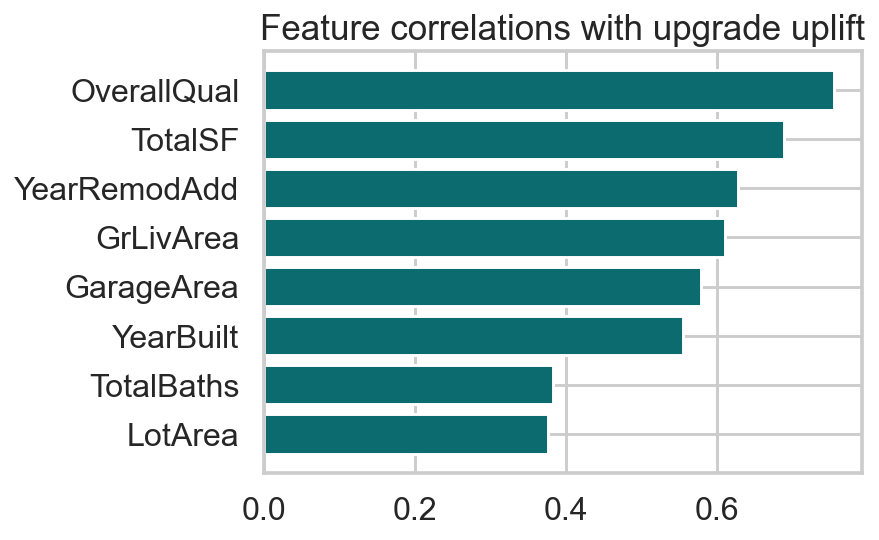

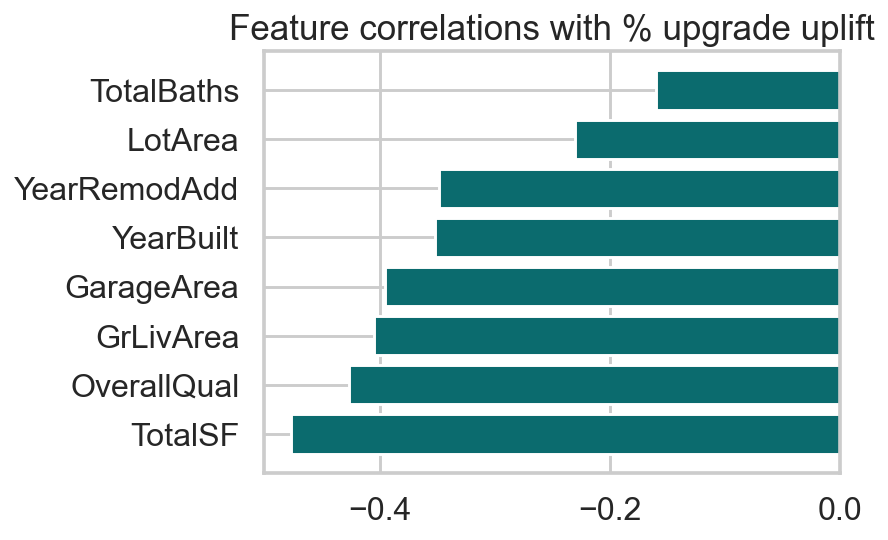

In [247]:
NUMERIC_FEATS = [
    "GarageArea","GrLivArea","TotalSF","YearBuilt",
    "LotArea","OverallQual","YearRemodAdd","TotalBaths"
]

# A) Top20% vs uplift in dollars
rho_top_dollars = spearman_vs_uplift(X_fe, top20pct, NUMERIC_FEATS, uplift_col="stacked_uplift")
plot_spearman_bars(rho_top_dollars, "Feature correlations with upgrade uplift")

# B) (Optional) use % uplift instead
rho_top_pct = spearman_vs_uplift(X_fe, top20pct, NUMERIC_FEATS, uplift_col="stacked_uplift_pct")
plot_spearman_bars(rho_top_pct, "Feature correlations with % upgrade uplift")

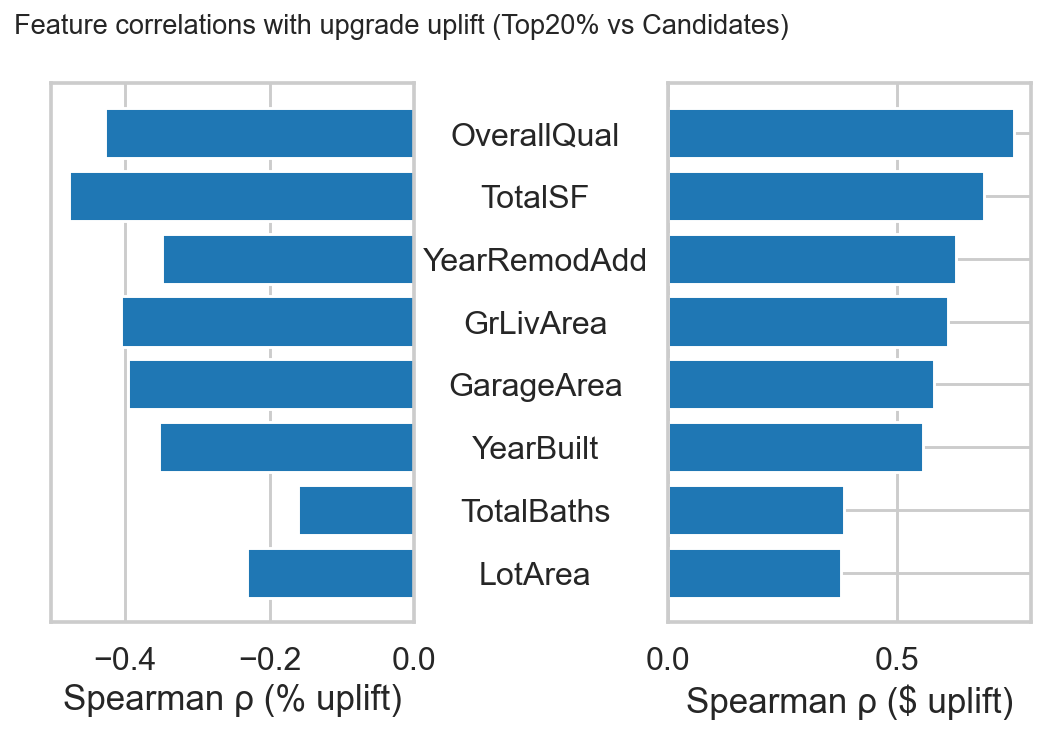

In [314]:
rho_merge = pd.merge(rho_top_dollars, rho_top_pct, on='feature')
df = rho_merge.dropna(subset=["rho_x"]).copy().sort_values("rho_x")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=140)
fig.subplots_adjust(wspace=0.7, left=0.25, right=0.95)

# Left: % uplift
ax1.barh(df["feature"], df["rho_y"].values)
ax1.set_xlabel("Spearman ρ (% uplift)")
ax1.set_yticks([])

# Right: $ uplift
ax2.barh(df["feature"], df["rho_x"].values)
ax2.set_xlabel("Spearman ρ ($ uplift)")

# Move y tick labels further left into the figure
for label in ax2.get_yticklabels():
    label.set_horizontalalignment("center")
    label.set_x(-0.3)   # shift left; adjust until it looks right

fig.suptitle("Feature correlations with upgrade uplift (Top20% vs Candidates)", fontsize=14)
plt.show()

In [167]:
def categorical_compare_table(
    X: pd.DataFrame,
    top_idx: np.ndarray,
    rest_idx: np.ndarray,
    feature: str,
    ordered: list[str] | None = None
) -> pd.DataFrame:
    """
    Build Top vs Rest frequency comparison for a categorical feature.
    """
    top_counts  = X.iloc[top_idx][feature].value_counts(normalize=True, dropna=False)
    rest_counts = X.iloc[rest_idx][feature].value_counts(normalize=True, dropna=False)

    df = pd.concat([top_counts, rest_counts], axis=1, keys=["Top","Rest"]).fillna(0.0)
    df["Ratio"] = df["Top"] / df["Rest"].replace(0, np.nan)

    # preserve order if provided
    if ordered is not None:
        cat_index = pd.CategoricalIndex(ordered, categories=ordered, ordered=True)
        df = df.reindex(cat_index).fillna(0.0)

    return df

In [168]:
top_idx  = top20pct["_idx"].to_numpy()
rest_idx = np.setdiff1d(candidates["_idx"].to_numpy(), top_idx, assume_unique=False)

tbl_neigh = categorical_compare_table(X_fe, top_idx, rest_idx, "Neighborhood")
tbl_zone  = categorical_compare_table(X_fe, top_idx, rest_idx, "MSZoning")
tbl_kit   = categorical_compare_table(
    X_fe, top_idx, rest_idx, "KitchenQual",
    ordered=["Po","Fa","TA","Gd","Ex"]
)
tbl_ext   = categorical_compare_table(
    X_fe, top_idx, rest_idx, "ExterQual",
    ordered=["Fa","TA","Gd","Ex"]
)

print("Neighborhood:\n", tbl_neigh.head(15))
print("\nMSZoning:\n", tbl_zone)
print("\nKitchenQual:\n", tbl_kit)
print("\nExterQual:\n", tbl_ext)

Neighborhood:
                 Top   Rest  Ratio
Neighborhood                     
NAmes        0.1852 0.1321 1.4015
OldTown      0.1667 0.0691 2.4130
Edwards      0.1481 0.0631 2.3492
CollgCr      0.1204 0.0931 1.2930
NWAmes       0.0556 0.0556 1.0000
Mitchel      0.0463 0.0405 1.1420
BrkSide      0.0463 0.0240 1.9271
SawyerW      0.0278 0.0465 0.5968
Sawyer       0.0278 0.0495 0.5606
Blmngtn      0.0278 0.0075 3.7000
SWISU        0.0278 0.0165 1.6818
IDOTRR       0.0278 0.0240 1.1562
Crawfor      0.0185 0.0375 0.4933
Timber       0.0185 0.0300 0.6167
MeadowV      0.0185 0.0180 1.0278

MSZoning:
             Top   Rest  Ratio
MSZoning                     
RL       0.7407 0.7868 0.9415
RM       0.2222 0.1426 1.5579
C (all)  0.0185 0.0090 2.0556
RH       0.0093 0.0105 0.8810
FV       0.0093 0.0511 0.1814

KitchenQual:
       Top   Rest  Ratio
Po 0.0000 0.0000 0.0000
Fa 0.0556 0.0210 2.6429
TA 0.7315 0.4384 1.6684
Gd 0.1852 0.4745 0.3903
Ex 0.0278 0.0661 0.4205

ExterQual:
       Top   R

In [173]:
import numpy as np
import pandas as pd

def categorical_compare_table(X, top_idx, rest_idx, feature, ordered=None):
    top_counts  = X.iloc[top_idx][feature].astype("object").value_counts(normalize=True, dropna=False)
    rest_counts = X.iloc[rest_idx][feature].astype("object").value_counts(normalize=True, dropna=False)
    df = pd.concat([top_counts, rest_counts], axis=1, keys=["Top","Rest"]).fillna(0.0)
    df["Ratio"] = df["Top"] / df["Rest"].replace(0, np.nan)
    if ordered is not None:
        df = df.reindex(ordered).fillna(0.0)
    return df

In [174]:
import matplotlib.pyplot as plt

def plot_kitchen_exterior_side_by_side(kit_tbl, ext_tbl, ymax=1.0):
    cats_kit = kit_tbl.index.tolist()
    cats_ext = ext_tbl.index.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), dpi=140, sharey=False)

    # --- Kitchen ---
    ax = axes[0]
    x = np.arange(len(cats_kit)); bw = 0.38
    ax.bar(x-bw/2, kit_tbl["Rest"]*100, width=bw, color=W["rest"], label="Rest")
    ax.bar(x+bw/2, kit_tbl["Top"]*100,  width=bw, color=W["top"],  label="Top")
    for i, r in enumerate(kit_tbl["Ratio"].values):
        if np.isfinite(r) and r > 0:
            ax.text(x[i]+bw/2, kit_tbl["Top"].iat[i]*100 + 1.3, f"{r:.1f}×",
                    ha="center", va="bottom", fontsize=10, color=W["ratio"])
    ax.set_xticks(x); ax.set_xticklabels(cats_kit)
    ax.set_ylim(0, ymax*100); ax.set_ylabel("Share of homes (%)")
    ax.set_title("Kitchen quality")
    ax.legend(loc="upper right", frameon=False)

    # --- Exterior ---
    ax = axes[1]
    x = np.arange(len(cats_ext))
    ax.bar(x-bw/2, ext_tbl["Rest"]*100, width=bw, color=W["rest"], label="Rest")
    ax.bar(x+bw/2, ext_tbl["Top"]*100,  width=bw, color=W["top"],  label="Top")
    for i, r in enumerate(ext_tbl["Ratio"].values):
        if np.isfinite(r) and r > 0:
            ax.text(x[i]+bw/2, ext_tbl["Top"].iat[i]*100 + 1.3, f"{r:.1f}×",
                    ha="center", va="bottom", fontsize=10, color=W["ratio"])
    ax.set_xticks(x); ax.set_xticklabels(cats_ext)
    ax.set_ylim(0, ymax*100); ax.set_ylabel("Share of homes (%)")
    ax.set_title("Exterior quality")
    ax.legend(loc="upper right", frameon=False)

    plt.tight_layout()
    plt.show()

In [175]:
def plot_neighborhood_top6(neigh_tbl, rotate=20):
    df = neigh_tbl.copy()
    # keep top 6 by over-representation (ratio), break ties by Top share
    df = (df.replace([np.inf, -np.inf], np.nan)
            .dropna(subset=["Ratio"])
            .sort_values(["Ratio","Top"], ascending=[False, False])
            .head(6)
            .sort_index())

    cats = df.index.tolist()
    x = np.arange(len(cats)); bw = 0.38

    plt.figure(figsize=(8.5, 4.2), dpi=140)
    plt.bar(x-bw/2, df["Rest"]*100, width=bw, color=W["rest"], label="Rest")
    plt.bar(x+bw/2, df["Top"]*100,  width=bw, color=W["top"],  label="Top")

    for i, r in enumerate(df["Ratio"].values):
        if np.isfinite(r) and r > 0:
            plt.text(x[i]+bw/2, df["Top"].iat[i]*100 + 0.8, f"{r:.1f}×",
                     ha="center", va="bottom", fontsize=9, color=W["ratio"])

    plt.xticks(x, cats, rotation=rotate, ha="right")
    plt.ylabel("Share of homes (%)")
    plt.title("Neighborhood (Top vs Rest — top 6 by ratio)")
    plt.legend(loc="upper right", frameon=False)
    plt.tight_layout(); plt.show()

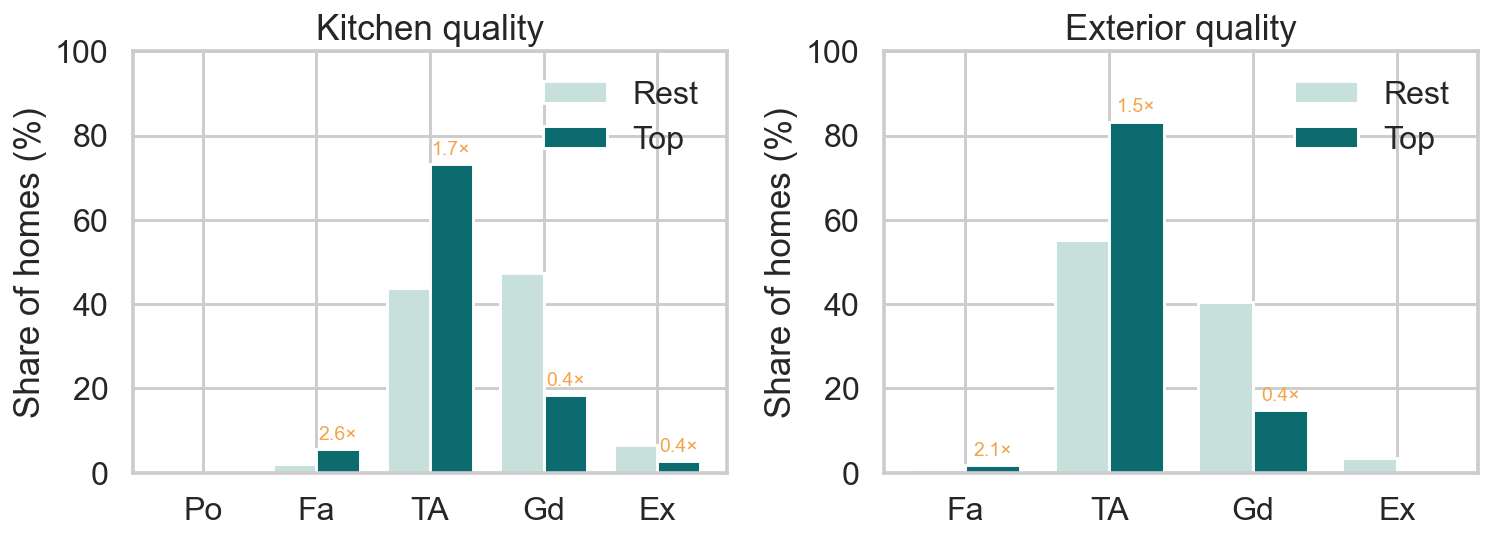

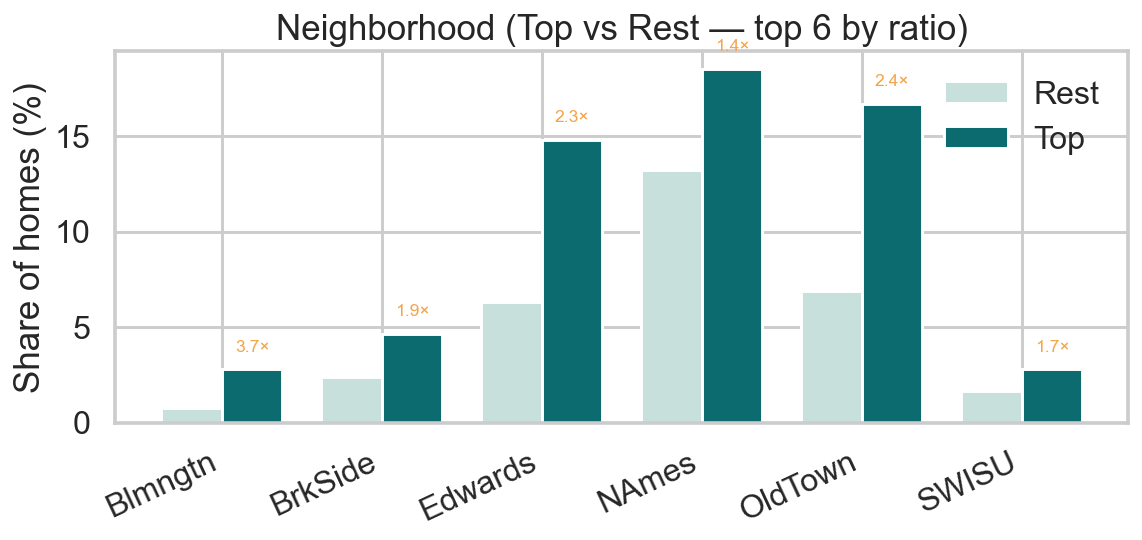

In [176]:
top_idx  = top20pct["_idx"].to_numpy()
rest_idx = np.setdiff1d(candidates["_idx"].to_numpy(), top_idx, assume_unique=False)

kit_tbl = categorical_compare_table(
    X_fe, top_idx, rest_idx, "KitchenQual",
    ordered=["Po","Fa","TA","Gd","Ex"]
)
ext_tbl = categorical_compare_table(
    X_fe, top_idx, rest_idx, "ExterQual",
    ordered=["Fa","TA","Gd","Ex"]
)
neigh_tbl = categorical_compare_table(X_fe, top_idx, rest_idx, "Neighborhood")

plot_kitchen_exterior_side_by_side(kit_tbl, ext_tbl, ymax=1.0)
plot_neighborhood_top6(neigh_tbl, rotate=25)

In [315]:
import numpy as np, pandas as pd

def bootstrap_ci(x, stat=np.median, B=2000, alpha=0.05, rng=None):
    """Percentile bootstrap CI for a 1-D array-like."""
    x = np.asarray(pd.to_numeric(x, errors="coerce").dropna())
    if x.size == 0:
        return np.nan, np.nan, np.nan
    r = np.random.default_rng(None if rng is None else rng)
    stats = np.empty(B, dtype=float)
    n = x.size
    for b in range(B):
        stats[b] = stat(x[r.integers(0, n, n)])
    lo, hi = np.quantile(stats, [alpha/2, 1 - alpha/2])
    return float(stat(x)), float(lo), float(hi)

def summarize_upgrades(upgrades_long: pd.DataFrame, *, min_n=20, alpha=0.05, rng=42):
    """
    Expect columns: ['upgrade','feature','uplift'] and (optionally) ['uplift_pct'].
    Returns a summary with median uplift, CI, and sample size.
    """
    need = {"upgrade","feature","uplift"}
    if not need.issubset(upgrades_long.columns):
        raise KeyError(f"upgrades_long must contain {need}. Found: {list(upgrades_long.columns)}")

    rows = []
    for (upg, feat), g in upgrades_long.groupby(["upgrade","feature"], dropna=False):
        med, lo, hi = bootstrap_ci(g["uplift"], stat=np.median, alpha=alpha, rng=rng)
        pct_med = np.median(pd.to_numeric(g.get("uplift_pct", pd.Series(index=g.index, dtype=float)), errors="coerce").dropna()
                            ) if "uplift_pct" in g.columns else np.nan
        rows.append({
            "upgrade": upg,
            "feature": feat,
            "n": int(len(g)),
            "median_uplift": med,
            "ci_lo": lo,
            "ci_hi": hi,
            "median_uplift_pct": float(pct_med) if pd.notna(pct_med) else np.nan
        })
    out = pd.DataFrame(rows)

    # keep only well-supported, clearly-positive upgrades
    sig = out.query("n >= @min_n and ci_lo > 0").copy()
    sig = sig.sort_values("median_uplift", ascending=False).reset_index(drop=True)
    return sig

In [323]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_uplift_bars(summary_df: pd.DataFrame, *,
                     title="Median Uplift ($) — significant upgrade types",
                     color="#0B6B6E", err_color="#111",
                     annotate_pct=True, top_n=8):
    if summary_df.empty:
        print("No significant upgrades to plot.")
        return

    # Top N by median uplift, then sort ASC and invert y so BIGGEST ends up at TOP
    df = (summary_df.nlargest(top_n, "median_uplift")
                      .sort_values("median_uplift", ascending=False)
                      .reset_index(drop=True))

    # numeric y positions (lets us place errorbars + text cleanly)
    y   = np.arange(len(df))
    med = df["median_uplift"].to_numpy()
    lo  = df["ci_lo"].to_numpy()
    hi  = df["ci_hi"].to_numpy()

    fig, ax = plt.subplots(figsize=(11, 4.5), dpi=140)

    # bars
    ax.barh(y, med, color=color, edgecolor="none")

    # error bars
    ax.errorbar(med, y, xerr=[med - lo, hi - med], fmt="none",
                ecolor=err_color, elinewidth=1.4, capsize=4, capthick=1.4)

    # y tick labels
    ax.set_yticks(y)
    ax.set_yticklabels(df["upgrade"].to_list(), fontsize=12)

    # BIGGEST at top
    ax.invert_yaxis()

    # $ formatting + generous right margin
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"${v:,.0f}"))
    xmax = float(np.nanmax(hi)) if np.isfinite(hi).any() else float(np.nanmax(med))
    ax.set_xlim(0, xmax * 1.20)          # more space on the right
    ax.margins(x=0.02)
    ax.set_title(title, fontsize=20, pad=10)

    # % annotations: outside if there’s room, otherwise inside-right with a white badge
    if annotate_pct and "median_uplift_pct" in df.columns:
        pct = df["median_uplift_pct"].to_numpy()
        pad = 0.04 * xmax                 # bump this up if you still see crowding
        right_lim = ax.get_xlim()[1]
        for xi, yi, p in zip(med, y, pct):
            if not np.isfinite(p): 
                continue
            outside_x = xi + pad
            if outside_x <= right_lim - pad*0.5:
                ax.text(outside_x, yi, f"{p*100:.1f}%", va="center", ha="left",
                        color="#F4A44B", fontsize=12, clip_on=False)
            else:
                ax.text(xi - pad*0.6, yi, f"{p*100:.1f}%", va="center", ha="right",
                        color="#F4A44B", fontsize=12, clip_on=False,
                        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=0.3))

    plt.tight_layout()
    plt.show()

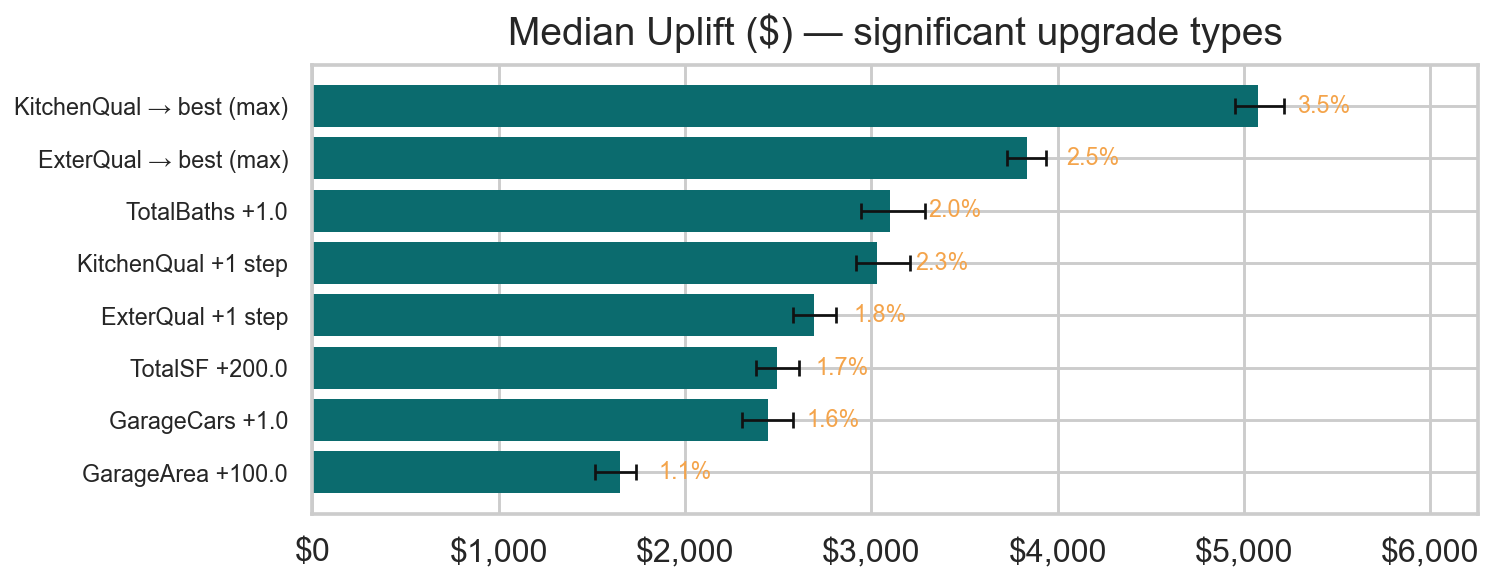

In [324]:
summary_sig = summarize_upgrades(upgrades_long, min_n=20, alpha=0.05, rng=42)
plot_uplift_bars(summary_sig, top_n=8)

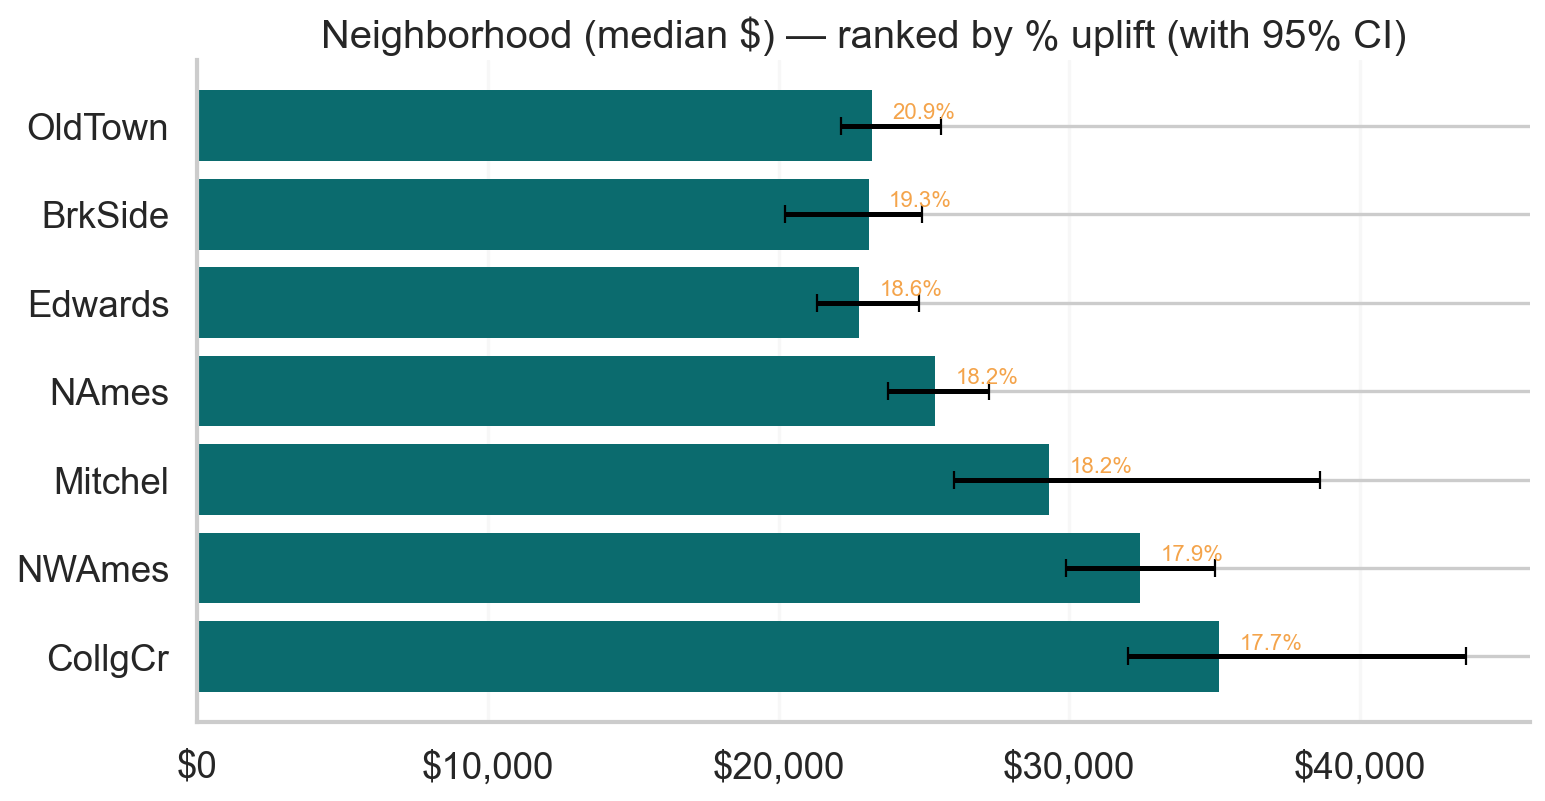

In [390]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

TEAL = "#0B6B6E"
GOLD = "#F4A44B"

def _money(x, _): return f"${x:,.0f}"

def bootstrap_ci(series, n_boot=1000, ci=95, random_state=42):
    """Bootstrap CI for the median of a pandas Series"""
    rng = np.random.default_rng(random_state)
    data = series.dropna().to_numpy()
    boots = [np.median(rng.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
    lower = np.percentile(boots, (100-ci)/2)
    upper = np.percentile(boots, 100-(100-ci)/2)
    return lower, upper

def plot_nb_median_uplift_with_errorbars(candidates_nb, top_k=10, min_n=8):
    # 1) Aggregate median uplift + bootstrap CI by neighborhood
    rows = []
    for nb, sub in candidates_nb.groupby("Neighborhood"):
        if len(sub) < min_n: 
            continue
        med = sub["stacked_uplift"].median()
        lo, hi = bootstrap_ci(sub["stacked_uplift"])
        pct = sub["stacked_uplift_pct"].median()
        rows.append({"Neighborhood": nb, "median_$": med, "pct": pct, "n": len(sub),
                     "ci_lo": lo, "ci_hi": hi})

    df = pd.DataFrame(rows).sort_values("pct", ascending=False).head(top_k)

    # 2) Plot with error bars
    fig, ax = plt.subplots(figsize=(10, 0.55*len(df) + 1.5), dpi=160)
    y = np.arange(len(df))
    ax.barh(y, df["median_$"], color=TEAL, edgecolor="none", xerr=[df["median_$"]-df["ci_lo"], df["ci_hi"]-df["median_$"]],
            capsize=4, ecolor="black")
    ax.set_yticks(y, labels=df["Neighborhood"])
    ax.invert_yaxis()

    # Format x-axis as dollars
    ax.xaxis.set_major_formatter(FuncFormatter(_money))
    ax.set_title("Neighborhood (median $) — ranked by % uplift (with 95% CI)")

    # Annotate with % uplift (shifted slightly upward)
    for i, (val, pct) in enumerate(zip(df["median_$"], df["pct"])):
        ax.text(val + df["median_$"].max()*0.02,   # x position (end of bar + offset)
                i - 0.15,                          # y position (shift up by 0.15)
                f"{pct:.1%}", 
                va="center", ha="left", color=GOLD, fontsize=10)

    ax.grid(axis="x", alpha=0.15)
    ax.spines[['top','right']].set_visible(False)
    plt.tight_layout()
    plt.show()

# --- usage ---
plot_nb_median_uplift_with_errorbars(candidates_nb, top_k=10, min_n=4)

In [434]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TEAL = "#0B6B6E"

def _fmt_money(v: float) -> str:
    return "" if pd.isna(v) else f"${int(round(v)):,}"

def _fmt_pct(v: float) -> str:
    # expects a fraction (0.025 => 2.5%)
    return "" if pd.isna(v) else f"{v*100:.1f}%"

def plot_upgrade_heatmaps(mat_dollar: pd.DataFrame,
                          mat_percent: pd.DataFrame,
                          title_suffix: str = "",
                          cmap_left: str = "Blues",
                          cmap_right: str = "Greens"):
    """
    Plot side-by-side heatmaps with pretty $ and % annotations.
    Assumes mat_percent entries are FRACTIONS (e.g., 0.031 not 3.1).
    """

    assert mat_dollar.shape == mat_percent.shape, "Dollar and percent matrices must align."

    # Build annotation arrays (same shape), keep underlying data numeric
    ann_money = mat_dollar.applymap(_fmt_money).values
    ann_pct   = mat_percent.applymap(_fmt_pct).values

    n_nb = mat_dollar.shape[0]
    fig_h = max(4, 0.5 * n_nb + 3)        # scale figure height with # of neighborhoods
    fig, axes = plt.subplots(1, 2, figsize=(15, fig_h), sharey=True)

    # Left: dollars
    sns.heatmap(
        mat_dollar, cmap=cmap_left,
        annot=ann_money, fmt="",            # <-- key change
        annot_kws={"fontsize": 9, "color": "#15202b"},
        cbar=False, linewidths=0.4, linecolor="#ddd",
        ax=axes[0]
    )
    axes[0].set_title(f"Median Uplift ($) {title_suffix}")
    axes[0].set_xlabel(""); axes[0].set_ylabel("")

    # Right: percents
    sns.heatmap(
        mat_percent, cmap=cmap_right,
        annot=ann_pct, fmt="",              # <-- key change
        annot_kws={"fontsize": 9, "color": "#15202b"},
        cbar=False, linewidths=0.4, linecolor="#ddd",
        ax=axes[1]
    )
    axes[1].set_title(f"Median Uplift (%) {title_suffix}")
    axes[1].set_xlabel(""); axes[1].set_ylabel("")

    # Rotate upgrade labels for readability
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    plt.tight_layout()
    plt.show()

/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_3814/2735192076.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ann_money = mat_dollar.applymap(_fmt_money).values
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_3814/2735192076.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ann_pct   = mat_percent.applymap(_fmt_pct).values


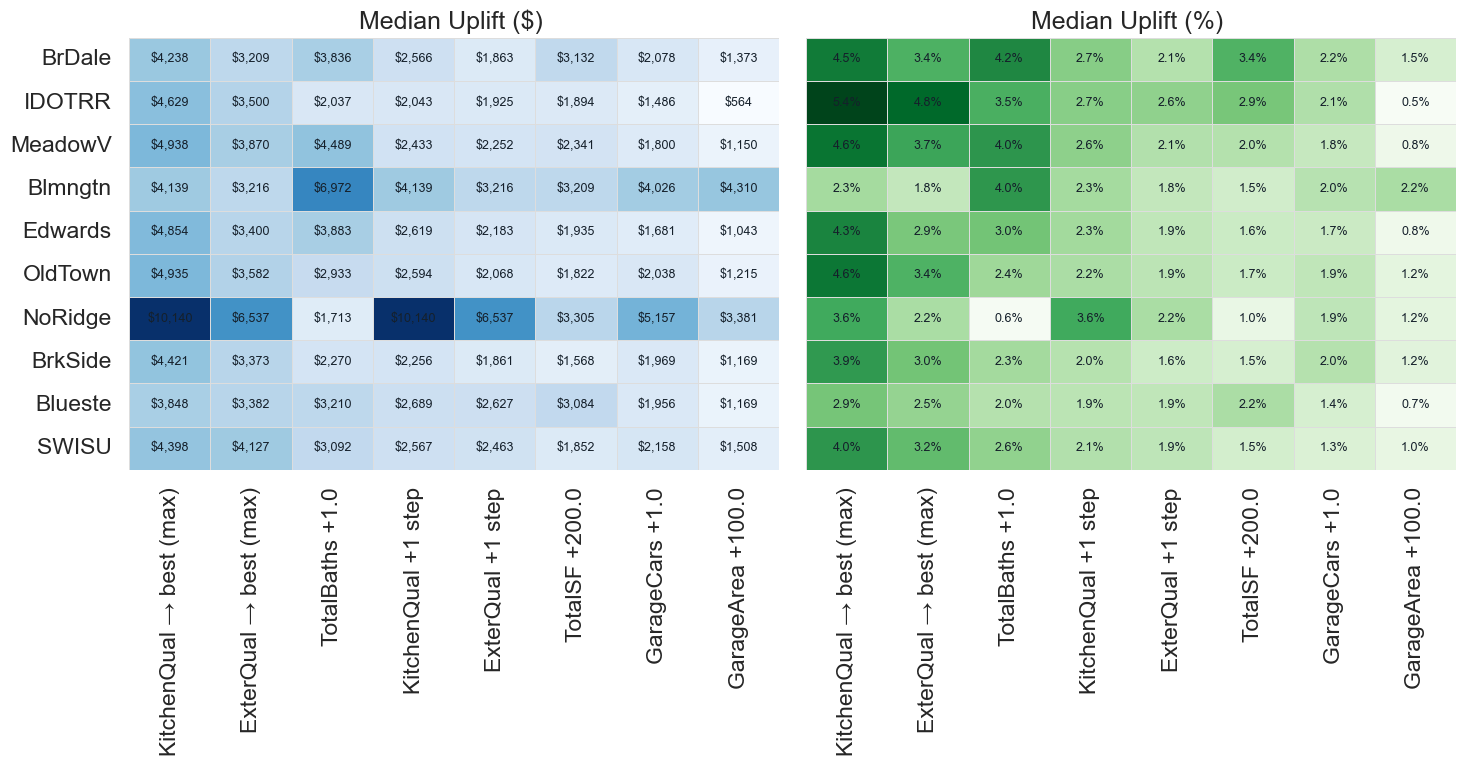

In [435]:
mat_dollar, mat_percent = build_heatmaps_input(
    upgrades_long,   # long table with columns: _idx, upgrade, uplift, base_pred_model, Neighborhood
    X_oof,           # lookup with _idx + Neighborhood (we join inside build_heatmaps_input)
    min_n_nbhd=8,
    top_k_nbhd=10,
    top_k_upgrades=8
)

plot_upgrade_heatmaps(mat_dollar, mat_percent, title_suffix="")

In [438]:
def build_heatmaps_input(upgrades_long, X_oof, min_n=8, top_k_nbhd=10, top_k_upgrades=8):
    import numpy as np
    import pandas as pd

    df = upgrades_long.merge(X_oof[["_idx","Neighborhood"]], on="_idx", how="left")

    # pick the available baseline column
    baseline_cols = ["base_pred", "baseline_pred_model", "oof_pred", "oof_pred_model", "base_pred_model"]
    base_col = next((c for c in baseline_cols if c in df.columns), None)
    if base_col is None:
        raise KeyError(f"None of the expected baseline columns are present: {baseline_cols}")

    # robust % uplift
    df["pct_uplift"] = df["uplift"] / df[base_col]

    # keep neighborhoods with enough sims
    valid_nb = df["Neighborhood"].value_counts()
    df = df[df["Neighborhood"].isin(valid_nb[valid_nb >= min_n].index)]

    # median matrices
    mat_dollar  = df.groupby(["Neighborhood","upgrade"])["uplift"].median().unstack()
    mat_percent = df.groupby(["Neighborhood","upgrade"])["pct_uplift"].median().unstack()

    # choose top upgrades by $ uplift
    if top_k_upgrades:
        top_upg = (df.groupby("upgrade")["uplift"]
                     .median().sort_values(ascending=False)
                     .head(top_k_upgrades).index)
        mat_dollar  = mat_dollar[top_upg]
        mat_percent = mat_percent[top_upg]

    # choose top neighborhoods by $ uplift
    if top_k_nbhd:
        top_nb = (df.groupby("Neighborhood")["uplift"]
                    .median().sort_values(ascending=False)
                    .head(top_k_nbhd).index)
        mat_dollar  = mat_dollar.loc[top_nb]
        mat_percent = mat_percent.loc[top_nb]

    return mat_dollar, mat_percent

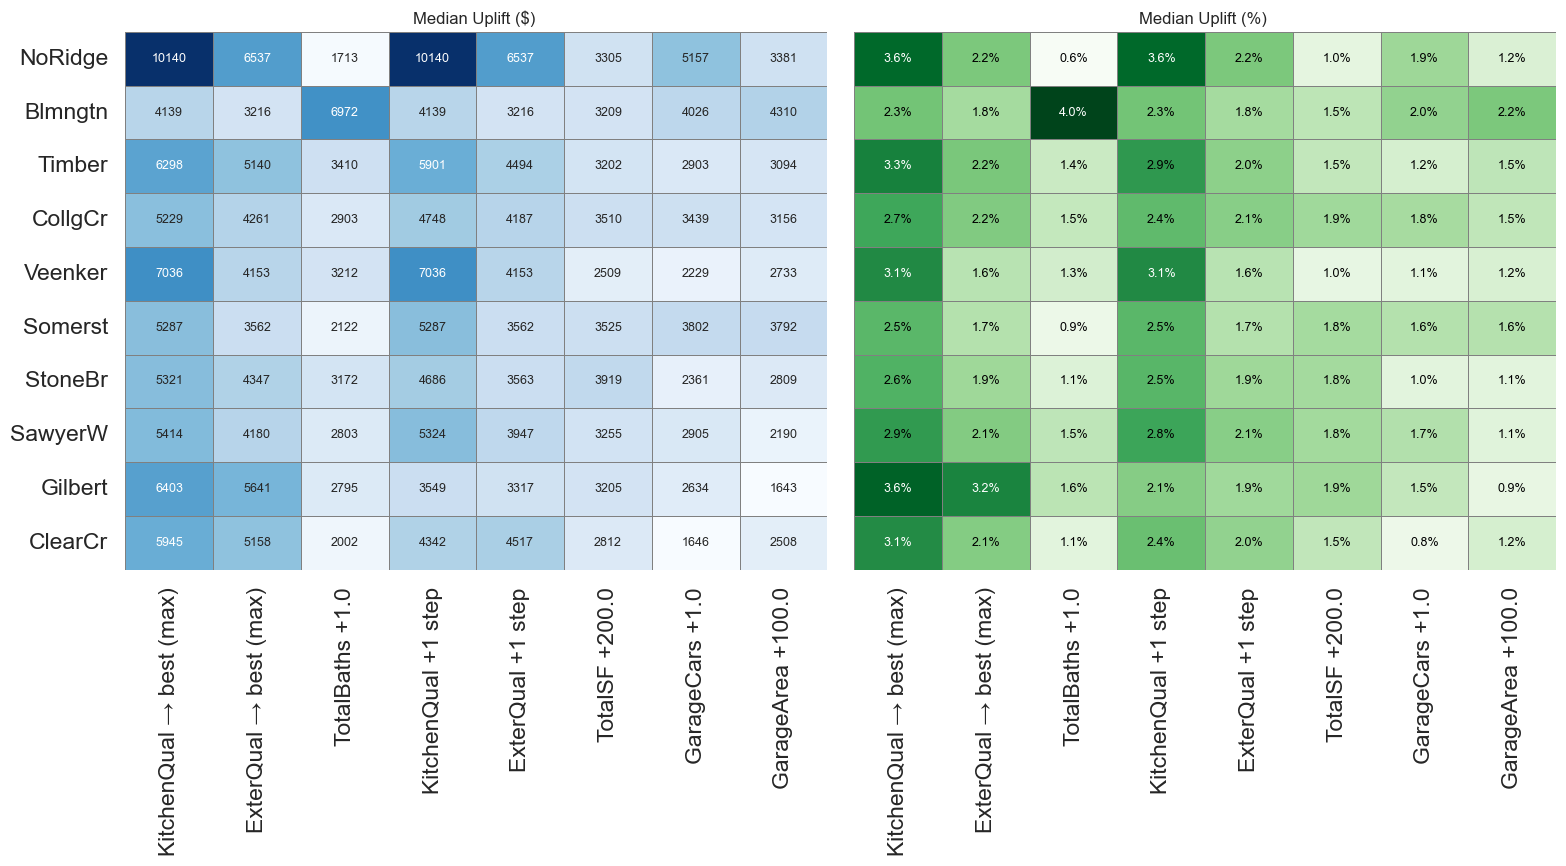

In [440]:
mat_dollar, mat_percent = build_heatmaps_input(
    upgrades_long, X_oof, min_n=8, top_k_nbhd=10, top_k_upgrades=8
)
plot_upgrade_heatmaps(mat_dollar, mat_percent, title_suffix="")